#  One-Shot Learning for plan symbols

## Overview

One-shot learning approach based on SimCLR embeddings:


Training (unsupervised):
- dataset of unlabeled images
- for each image: generation of two augmented views using strong transforms (random crop-resize, color jitter, horizontal flip). A batch of N images becomes 2N views
- model optimize the NT-Xent contrastive loss, to increase similarity between the two views of the same image (positive pair) and pushes apart all other images in the batch (negative pairs)


Architecture:
- ResNet_backbone + Projection head(Linear + ReLU + Linear)
- Head removed for inference

Inference (one example per class):
- The user provides one reference image per class.
- New image encoded with the backbone and classified using nearest-neighbor with cosine similarity in the embedding space.


Reference: SimCLR (Chen et al., 2020) — https://arxiv.org/abs/2002.05709






In [1]:
!pip install torch
!pip install timm
!pip install roboflow

  Using cached roboflow-1.2.11-py3-none-any.whl.metadata (9.7 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached pi_heif-0.18.0.tar.gz (16.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pillow_avif_plugin-1.5.2-cp38-cp38-macosx_11_0_arm64.whl.metadata (1.9 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
Using cached roboflow-1.2.11-py3-none-any.whl (89 kB)
Using cached idna-3.7-py3-none-any.whl (66 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl (54.8 MB)
Using cached pillow_avif_plugin-1.5.2-cp38-cp38-macosx_11_0_arm64.whl (2.8 MB)
Using cached filetype-1

In [5]:
import os
from PIL import Image

import torch
import torchvision.transforms  as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

import numpy as np


import random

import math

from tqdm import tqdm


from IPython.display import clear_output

## Data processing

In [6]:
'''1'''
'''The link may expire and also may not work if no roboflow account'''
if not os.path.exists("firefighting-device-detection"):
    !wget "https://universe.roboflow.com/ds/EvHxmLAvmh?key=skA3n0O0ky" -O firefighting-device-detection.zip
    !unzip -q firefighting-device-detection.zip -d firefighting-device-detection
    !rm firefighting-device-detection.zip
else:
    print("Dataset already loaded")


Dataset already loaded


In [7]:
from roboflow import Roboflow
import roboflow as rf

'''2'''
'''If roblox API key'''
if not os.path.exists("firefighting-device-detection"):
    rf = Roboflow(api_key="")
    project = rf.workspace("yaid-pzikt").project("firefighting-device-detection")
    dataset = project.version(6).download("yolov8",location="firefighting-device-detection")
else:
    print("Dataset already loaded")

ModuleNotFoundError: No module named 'roboflow'

### Cropping the symbols


To focus on the symbols themselves, we extract crops using the bounding boxes produced by YOLO.  
As SimCLR is self-supervised, the labels are not needed during training.


In [8]:
class YoloCropExtractor:
    def __init__(self, root_dir):
        self.img_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.save_dir = os.path.join(root_dir, "images_cropped")
        os.makedirs(self.save_dir, exist_ok=True)

    def extract(self):
        for fname in sorted(os.listdir(self.img_dir)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            img_path = os.path.join(self.img_dir, fname)
            label_path = os.path.join(self.label_dir, fname).replace(".jpg", ".txt").replace(".png", ".txt")
            if not os.path.exists(label_path):
                continue

            image = Image.open(img_path).convert("RGB")
            W, H = image.size

            with open(label_path, "r") as f:
                for i, line in enumerate(f.readlines()):
                    cls, x, y, w, h = map(float, line.strip().split())
                    x1, y1 = int((x - w / 2) * W), int((y - h / 2) * H)
                    x2, y2 = int((x + w / 2) * W), int((y + h / 2) * H)
                    crop = image.crop((x1, y1, x2, y2))
                    crop_filename = f"{os.path.splitext(fname)[0]}_{i}_cls{int(cls)}.jpg"
                    crop.save(os.path.join(self.save_dir, crop_filename))


In [9]:
root_dir = "firefighting-device-detection/train"
extractor_train = YoloCropExtractor(root_dir)
extractor_train.extract()

root_dir = "firefighting-device-detection/valid"
extractor_valid = YoloCropExtractor(root_dir)
extractor_valid.extract()

root_dir = "firefighting-device-detection/test"
extractor_test = YoloCropExtractor(root_dir)
extractor_test.extract()

To better understand the dataset, we inspect a few randomly selected crops:

- The dataset is very small (~2500 crops).  
- Many images are visually almost identical, since they correspond to the same symbol.  
- This lack of visual diversity will makes it harder for the contrastive model to learn strongly discriminative representations

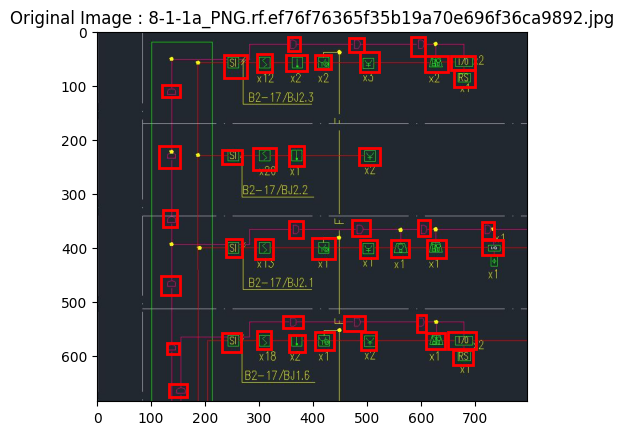

Base name used for matching: 8-1-1a_PNG.rf.ef76f76365f35b19a70e696f36ca9892
Cropped dir: firefighting-device-detection/train/images_cropped

43 crops found in 8-1-1a_PNG.rf.ef76f76365f35b19a70e696f36ca9892.jpg


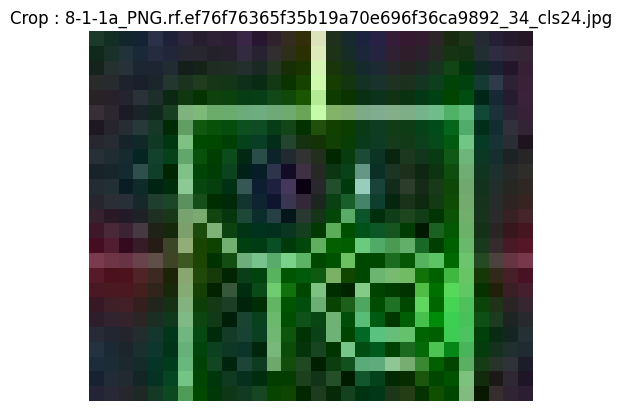

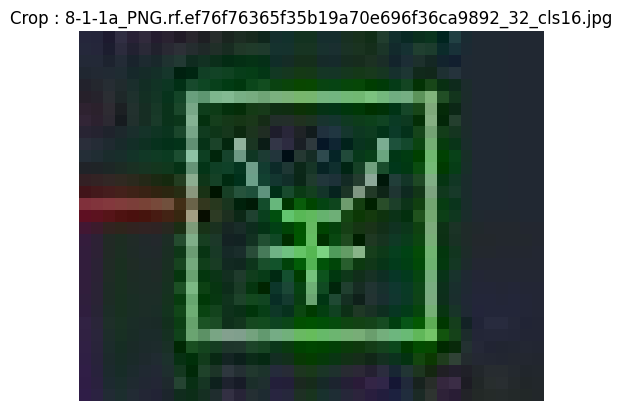

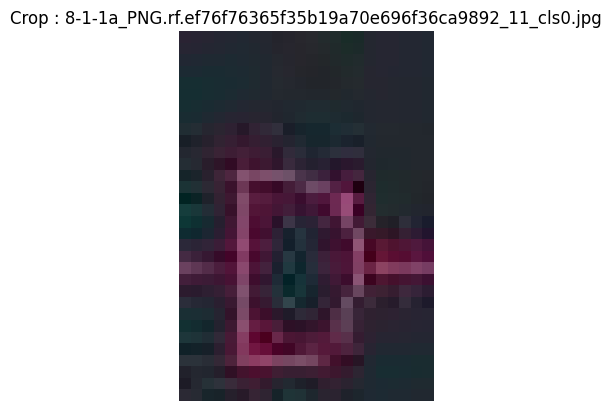

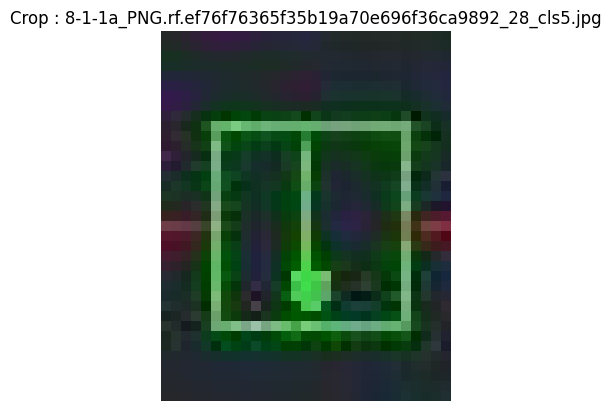

In [9]:
img_files = [f for f in os.listdir(extractor_train.img_dir) if f.endswith((".jpg", ".png"))]
random_img = random.choice(img_files)
img_path = os.path.join(extractor_train.img_dir, random_img)
label_path = os.path.join(extractor_train.label_dir, random_img).replace(".jpg", ".txt").replace(".png", ".txt")

image = Image.open(img_path).convert("RGB")
W, H = image.size

fig, ax = plt.subplots(1)
ax.imshow(image)
ax.set_title(f"Original Image : {random_img}")

if os.path.exists(label_path):
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x, y, w, h = map(float, line.strip().split())
            x1, y1 = (x - w/2) * W, (y - h/2) * H
            rect = patches.Rectangle((x1, y1), w * W, h * H,
                                        linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

plt.show()

base_name = os.path.splitext(random_img)[0]
print("Base name used for matching:", base_name)
print("Cropped dir:", extractor_train.save_dir)
cropped_files = [f for f in os.listdir(extractor_train.save_dir) if base_name in f]

print(f"\n{len(cropped_files)} crops found in {random_img}")

for crop_file in cropped_files[:4]:
    crop = Image.open(os.path.join(extractor_train.save_dir, crop_file))
    plt.imshow(crop)
    plt.title(f"Crop : {crop_file}")
    plt.axis('off')
    plt.show()


In [10]:
class CroppedSimCLRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.cropped_dir = os.path.join(root_dir, "images_cropped")
        self.transform = transform
        self.image_files = sorted([
            os.path.join(self.cropped_dir, f)
            for f in os.listdir(self.cropped_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = Image.open(self.image_files[idx]).convert("RGB")
        if self.transform:
            img1 = self.transform(img)
            img2 = self.transform(img)
        else:
            img1 = img
            img2 = img
        return img1, img2


### Transformations used during training

**augmentation_transform**  
Used to generate the two augmented views required by SimCLR.  
It includes:
- random resized crop  
- random horizontal flip  
- random color jitter (brightness, contrast, saturation)  
- random grayscale  
- **no Gaussian blur** because the symbol crops are low-resolution and contain fine line details that would be lost  



**conversion_transform**  
Used to ensure that images follow the formatting expected by ResNet:
- resizing / normalization  
- consistent preprocessing with ImageNet-trained weights

In [11]:

augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(13)
])

conversion_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

transform=transforms.Compose([augmentation_transform,conversion_transform])

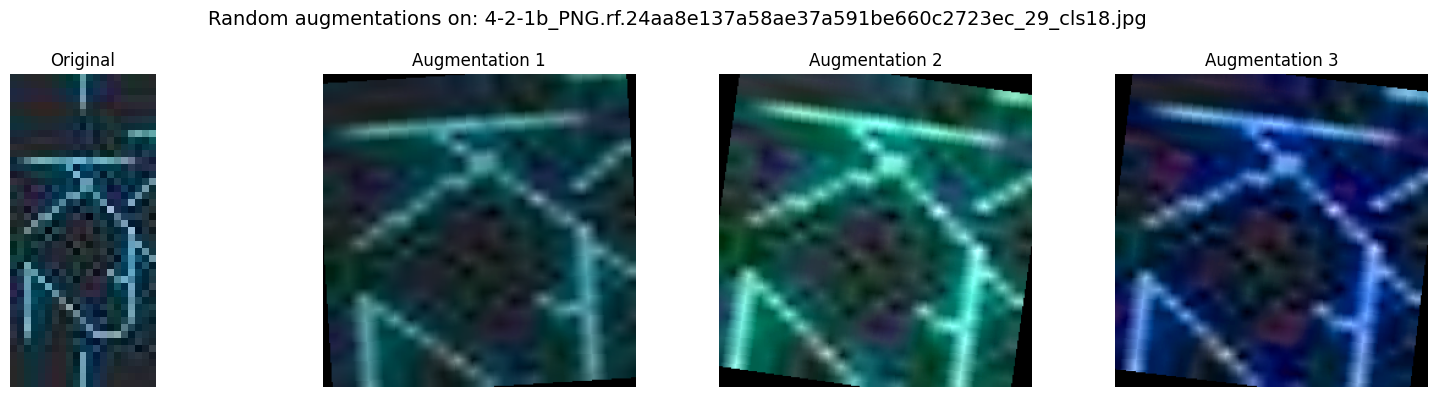

In [13]:
'''We check the transformation to gain more intution but in reality they are only applied at the very end by the DataLoader.
Plotted in black and white but in reality the transformations also change the colors.

'''
cropped_dir = extractor_train.save_dir

img_files = [f for f in os.listdir(cropped_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
random_img = random.choice(img_files)
img_path = os.path.join(cropped_dir, random_img)

img = Image.open(img_path).convert("RGB")

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis("off")

for i in range(1, 4):
    aug_img = augmentation_transform(img)
    axes[i].imshow(aug_img)
    axes[i].set_title(f"Augmentation {i}")
    axes[i].axis("off")

plt.suptitle(f"Random augmentations on: {random_img}", fontsize=14)
plt.tight_layout()
plt.show()

## Model Architecture

### Model choices

Two architectural choices had to be made:

- **Backbone:** ResNet18 vs. ResNet50  
- **Embedding dimensionality:** 128 vs. 256  

Given the small dataset (~3000 images) and limited compute budget, **ResNet18 with a 128-dimensional embedding** is the most reasonable option.  
ResNet18 has roughly **11M parameters**, which is already large relative to the size of the dataset.  
SimCLR partially compensates for this by generating **two strongly augmented views** of each image at every epoch, increasing the effective diversity seen during training.

---

### Initialization

We initialize the backbone with **ImageNet pretrained weights**, which stabilizes training


In [34]:
class ResNetSimCLR(nn.Module):
    def __init__(self, base_model="resnet18", out_dim=128):
        super().__init__()
        base = getattr(models, base_model)(weights="IMAGENET1K_V1")
        dim_mlp = base.fc.in_features
        base.fc = nn.Sequential(
            nn.Linear(dim_mlp, dim_mlp),
            nn.ReLU(),
            nn.Linear(dim_mlp, out_dim)
        )
        self.backbone = base

    def forward(self, x):
        return self.backbone(x)

### NT-Xent (InfoNCE) Loss

The contrastive loss used in SimCLR is defined as:

$$
\mathcal{L} = \frac{1}{2N} \sum_{i=1}^{2N}
-\log \frac{\exp\left( \text{sim}(z_i, z_{i}^{+}) / \tau \right)}
{\sum_{\substack{k=1 \\ k\neq i}}^{2N} \exp\left(\text{sim}(z_i, z_k)/\tau\right)}
$$



Increasing in the temperature: model less discriminative between the positive and the negative

Some extensions of contrastive learning use triplets of transformations instead of couples, which can help when the dataset is small. These variants were not explored here due to time constraints but could be relevant in this context.

In [16]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.3):
        super().__init__()
        self.temperature = temperature

    def forward(self, z1, z2):

        batch_size = z1.size(0)
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        z = torch.cat([z1, z2], dim=0)
        sim = torch.matmul(z, z.T) / self.temperature
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
        sim = sim.masked_fill(mask, float('-inf'))
        pos_idx = torch.arange(batch_size, device=z.device)
        pos_idx = torch.cat([pos_idx + batch_size, pos_idx], dim=0)
        positives = torch.exp(sim[torch.arange(2*batch_size), pos_idx])
        denominators = torch.exp(sim).sum(dim=1)
        loss = -torch.log(positives / denominators)

        return loss.mean()

## Hyperparameters and training strategy

Many interacting hyperparameters and limited compute budget: no extensive grid search possible.  
Approach: to monitor both training and validation contrastive losses and stop as soon as the validation loss began to increase.

---

### Quick tests and constraints

For a few rapid experiments (mainly on the temperature), some backbone layers were temporarily frozen to reduce computation time.

Key considerations during exploration:

- **High overfitting risk** due to the small dataset → regularization important.  
- **Batch size** strongly impacts SimCLR since larger batches provide more negative samples. Tested values: **64 and 128**.  
- **Learning rate scaling** was adjusted proportionally when increasing the batch size.  
- **Temperature τ** tested values: **0.3, 0.5, 0.6**. The model behaved more reliably with **τ = 0.6**.

---

### Optimizer and scheduling

Given the number of hyperparameters involved (learning rate, weight decay, temperature, batch size), a stable optimization setup was needed:

- **AdamW** was used for its robustness and more reliable regularization.  
- A **learning rate scheduler** was added to progressively reduce the learning rate across epochs.  

The resulting training curves with AdamW + scheduler were stable and behaved as expected (see below).


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr=0.001
temperature=0.3
base_model='resnet18'
out_dim=128
weight_decay=5e-5
batch_size=64
num_epochs=15
adam_with_weight_decay=True
with_scheduler=True

In [53]:
model_hp = ResNetSimCLR(base_model=base_model,out_dim=out_dim).to(device)

In [17]:
criterion = NTXentLoss(temperature=temperature)

In [ ]:
if adam_with_weight_decay:
  optimizer = optim.AdamW(model_hp.parameters(), lr=lr, weight_decay=weight_decay)
else:
  optimizer = optim.Adam(model_hp.parameters(), lr=lr, weight_decay=weight_decay)

if with_scheduler:
  def warmup_cosine_scheduler(optimizer, num_epochs, warmup_ratio=0.1, lr_min_ratio=0.2):
      warmup_epochs = int(num_epochs * warmup_ratio)
      cosine_epochs = num_epochs - warmup_epochs

      def lr_lambda(epoch):
          if epoch < warmup_epochs:
              return epoch / warmup_epochs
          else:
              progress = (epoch - warmup_epochs) / cosine_epochs
              cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
              return lr_min_ratio + (1 - lr_min_ratio) * cosine_decay

      return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

  scheduler = warmup_cosine_scheduler(optimizer, num_epochs=num_epochs)

In [ ]:
train_set=CroppedSimCLRDataset(root_dir="./firefighting-device-detection/train",transform=transform)
train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True, num_workers=4,pin_memory=True,persistent_workers=True)

validation_set=CroppedSimCLRDataset(root_dir="./firefighting-device-detection/valid",transform=transform)
validation_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True, num_workers=4,pin_memory=True,persistent_workers=True)

Live plotting of the loss to potentially stop before the end


In [ ]:
'''Live plotting of the loss so that I can stop before the end. '''

train_losses = []
val_losses = []

plt.ion()

for epoch in range(num_epochs):
    model_hp.train()
    training_loss = 0.0
    for images_T1, images_T2 in train_loader:
        images_T1, images_T2 = images_T1.to(device), images_T2.to(device)
        outputs_T1 = model_hp(images_T1)
        outputs_T2 = model_hp(images_T2)
        loss = criterion(outputs_T1, outputs_T2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Training loss for epoch {epoch}: {avg_train_loss:.4f}")

    model_hp.eval()
    validation_loss = 0

    with torch.no_grad():
        for images_T1, images_T2 in validation_loader:
            images_T1, images_T2 = images_T1.to(device), images_T2.to(device)
            outputs_T1 = model_hp(images_T1)
            outputs_T2 = model_hp(images_T2)
            loss = criterion(outputs_T1, outputs_T2)
            validation_loss += loss.item()
    avg_val_loss = validation_loss / len(validation_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation loss for epoch {epoch}: {avg_val_loss:.4f}")
    if with_scheduler:
      scheduler.step()

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.pause(0.1)

plt.ioff()

if with_scheduler:
  if adam_with_weight_decay:
    filename = f"loss_curve_adamw_scheduler_model={base_model}_out{out_dim}_lr{lr}_batch{batch_size}.png"
  else:
    filename = f"loss_curve_scheduler_model={base_model}_out{out_dim}_lr{lr}_batch{batch_size}.png"
else:
  if adam_with_weight_decay:
    filename = f"loss_curve_adamw_model={base_model}_out{out_dim}_lr{lr}_batch{batch_size}.png"
  else:
    filename = f"loss_curve_model={base_model}_out{out_dim}_lr{lr}_batch{batch_size}.png"

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training vs Validation Loss (model={base_model},out_dim={out_dim},lr={lr},batch{batch_size}")
plt.legend()
plt.grid(True)
plt.savefig(filename, bbox_inches='tight')
print(f"Saved plot as {filename}")

### Training curves and observations

Below are three training curves that illustrate how different choices affect the learning dynamics.

#### 1. ResNet50 (top curve)

- Model clearly **too large** for the dataset size.  
- The validation contrastive loss increases quickly, showing overfitting.  
- As expected, ResNet50 has far too many parameters relative to ~3000 crops.

---

#### 2. ResNet18 baseline (middle curve)

Configuration:
- backbone: **ResNet18**  
- embedding dimension: **128**  
- temperature: **0.3**  
- batch size: **64**  
- learning rate: **2e-4**  
- weight decay: **1e-4**  
- epochs: **8**

Observation:
- Overfitting starts around **epoch 7**, but training was still run to completion due to limited available compute.  


---

#### 3. ResNet18 + AdamW + Scheduler (bottom curve)

- Same configuration as the middle run, but using **AdamW** and a **learning-rate scheduler**.  
- This results in **smoother** and more stable curves.  
- The scheduled decay helps control overfitting and improves optimization stability.




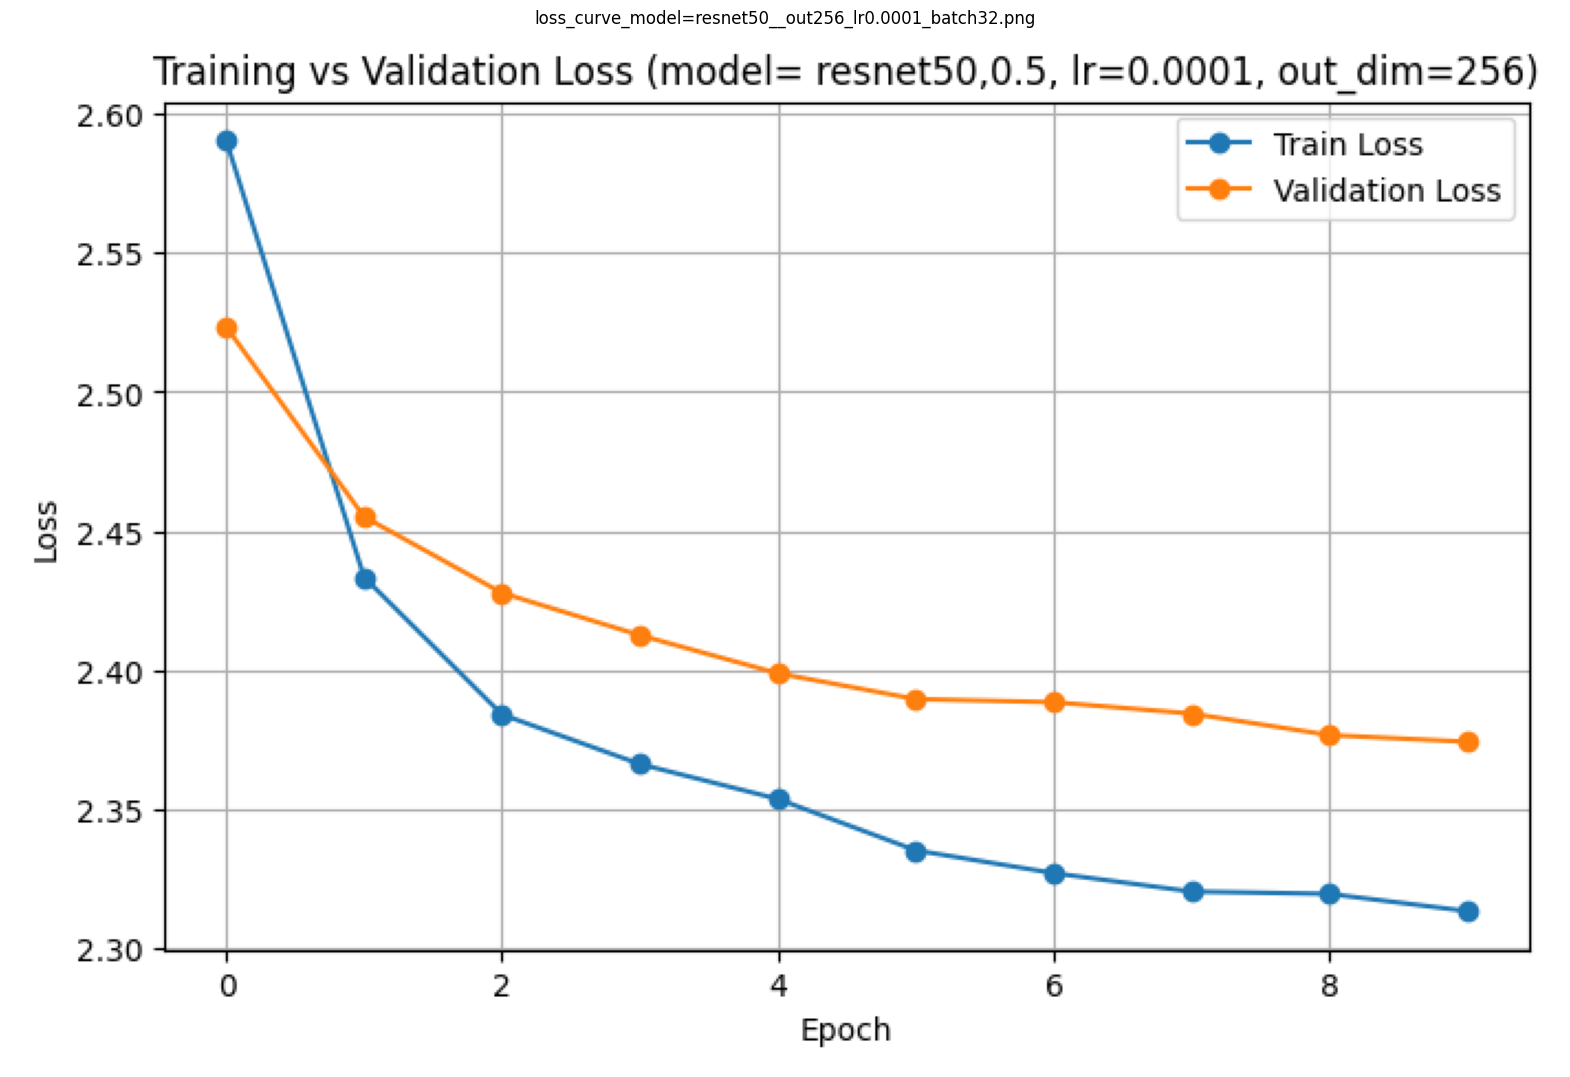

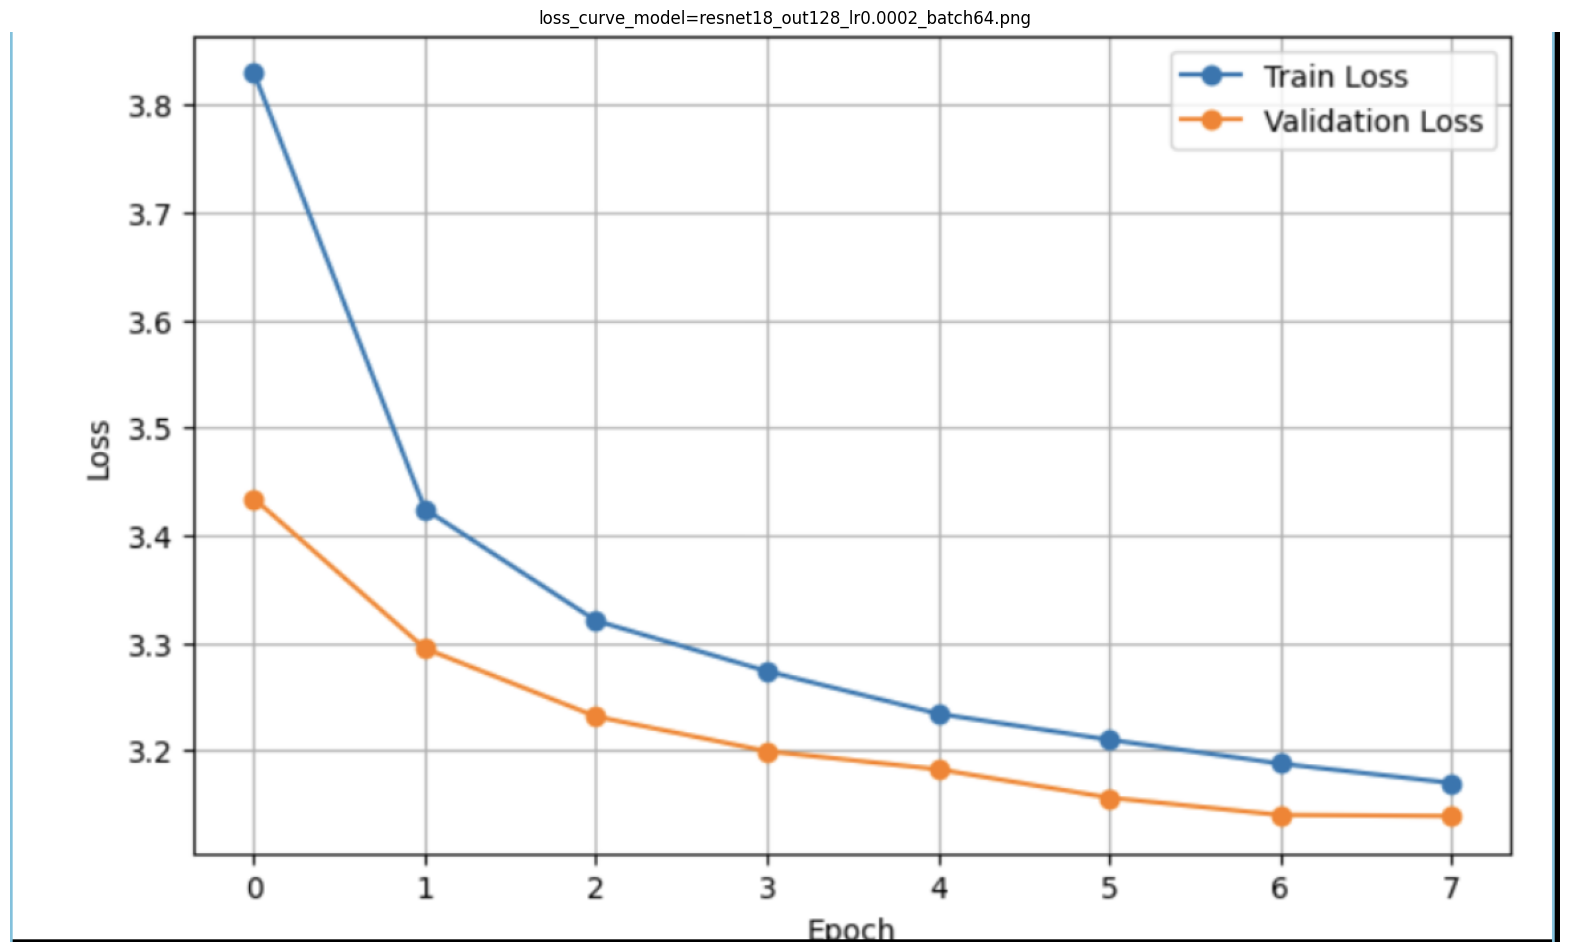

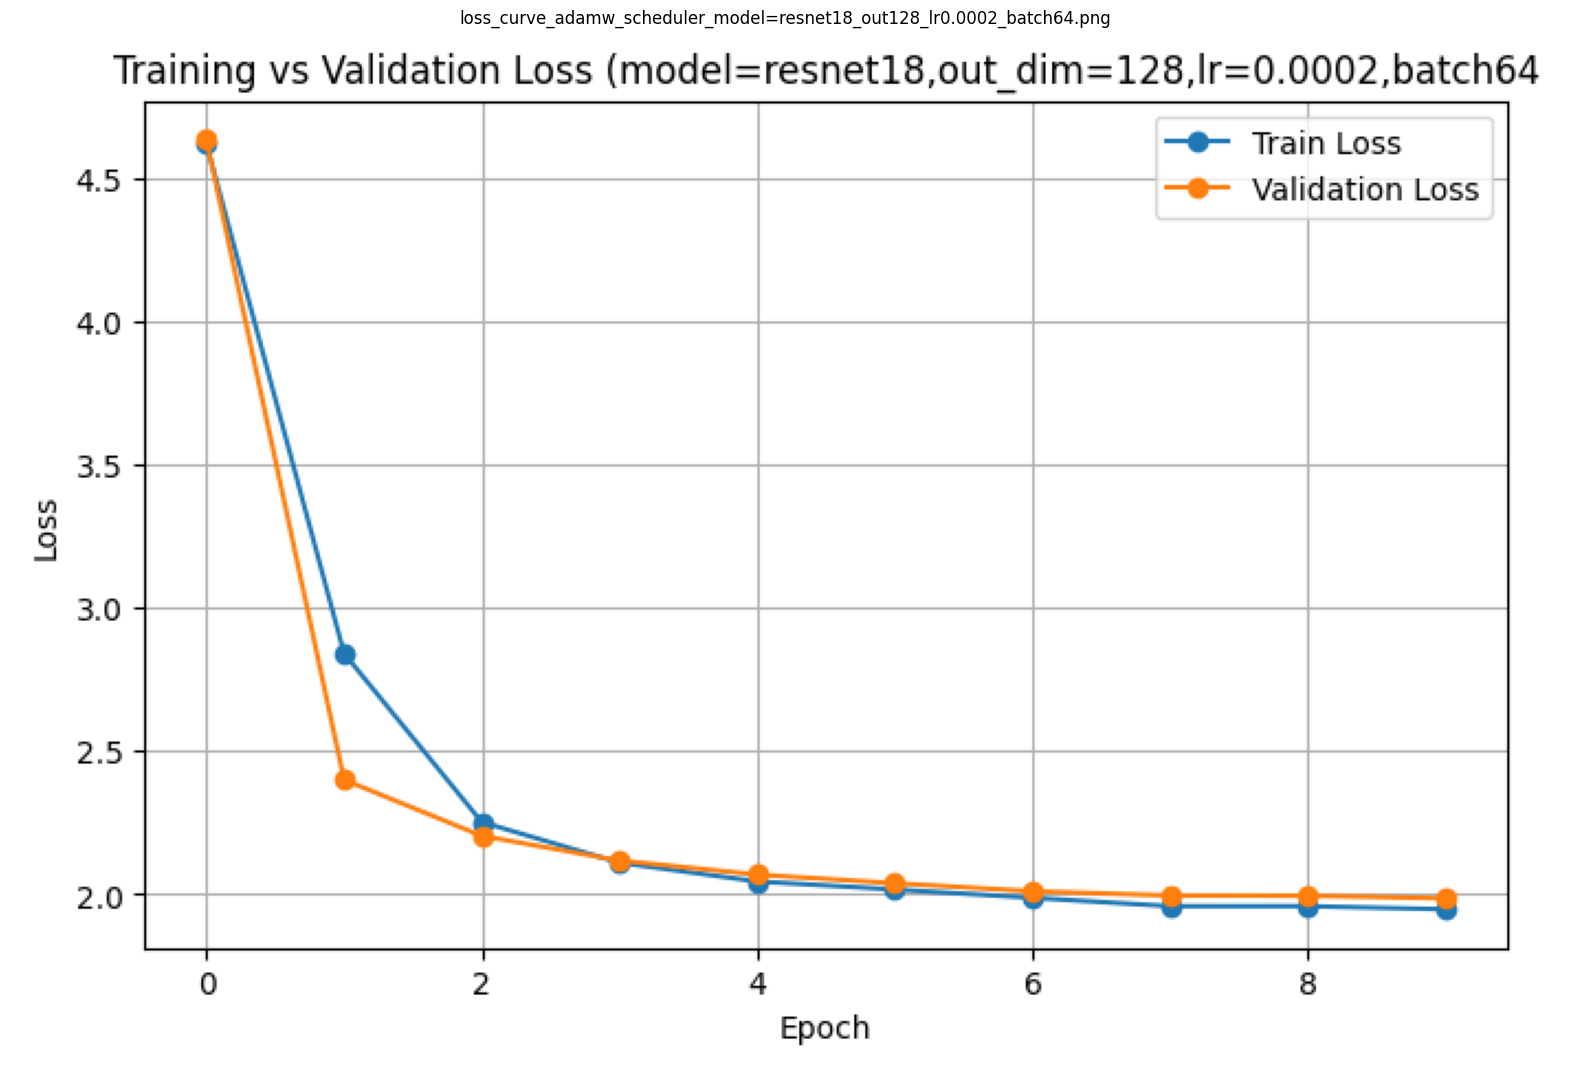

In [ ]:
images = ["loss_curve_model=resnet50__out256_lr0.0001_batch32.png",
        "loss_curve_model=resnet18_out128_lr0.0002_batch64.png",
        "loss_curve_adamw_scheduler_model=resnet18_out128_lr0.0002_batch64.png"
            ]


for img_path in images:
    img = mpimg.imread(img_path)
    plt.figure(figsize=(20, 15))
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_path)
    plt.show()

### Further experiments with AdamW and scheduling

After switching to **AdamW** and adding a learning-rate scheduler, additional experiments run to understand their impact on training stability.


#### Impact of batch size

- Results were slightly better with batch size = 64 than with 128.  
- Consistent with small datasets: a larger batch provides more negatives but also reduces gradient noise, which can make optimization harder when data is limited.


#### Impact of learning rate

- Initial learning rate had little visible impact, likely because the scheduler quickly adjusts it during training.  


#### Adjusting weight decay

- Once the contrastive loss began to **plateau** and no overfitting was detected, the*weight decay was reduced from 1e-4 to 2e-5 to avoid excessive regularization.  
- This helped stabilize the final stage of training.

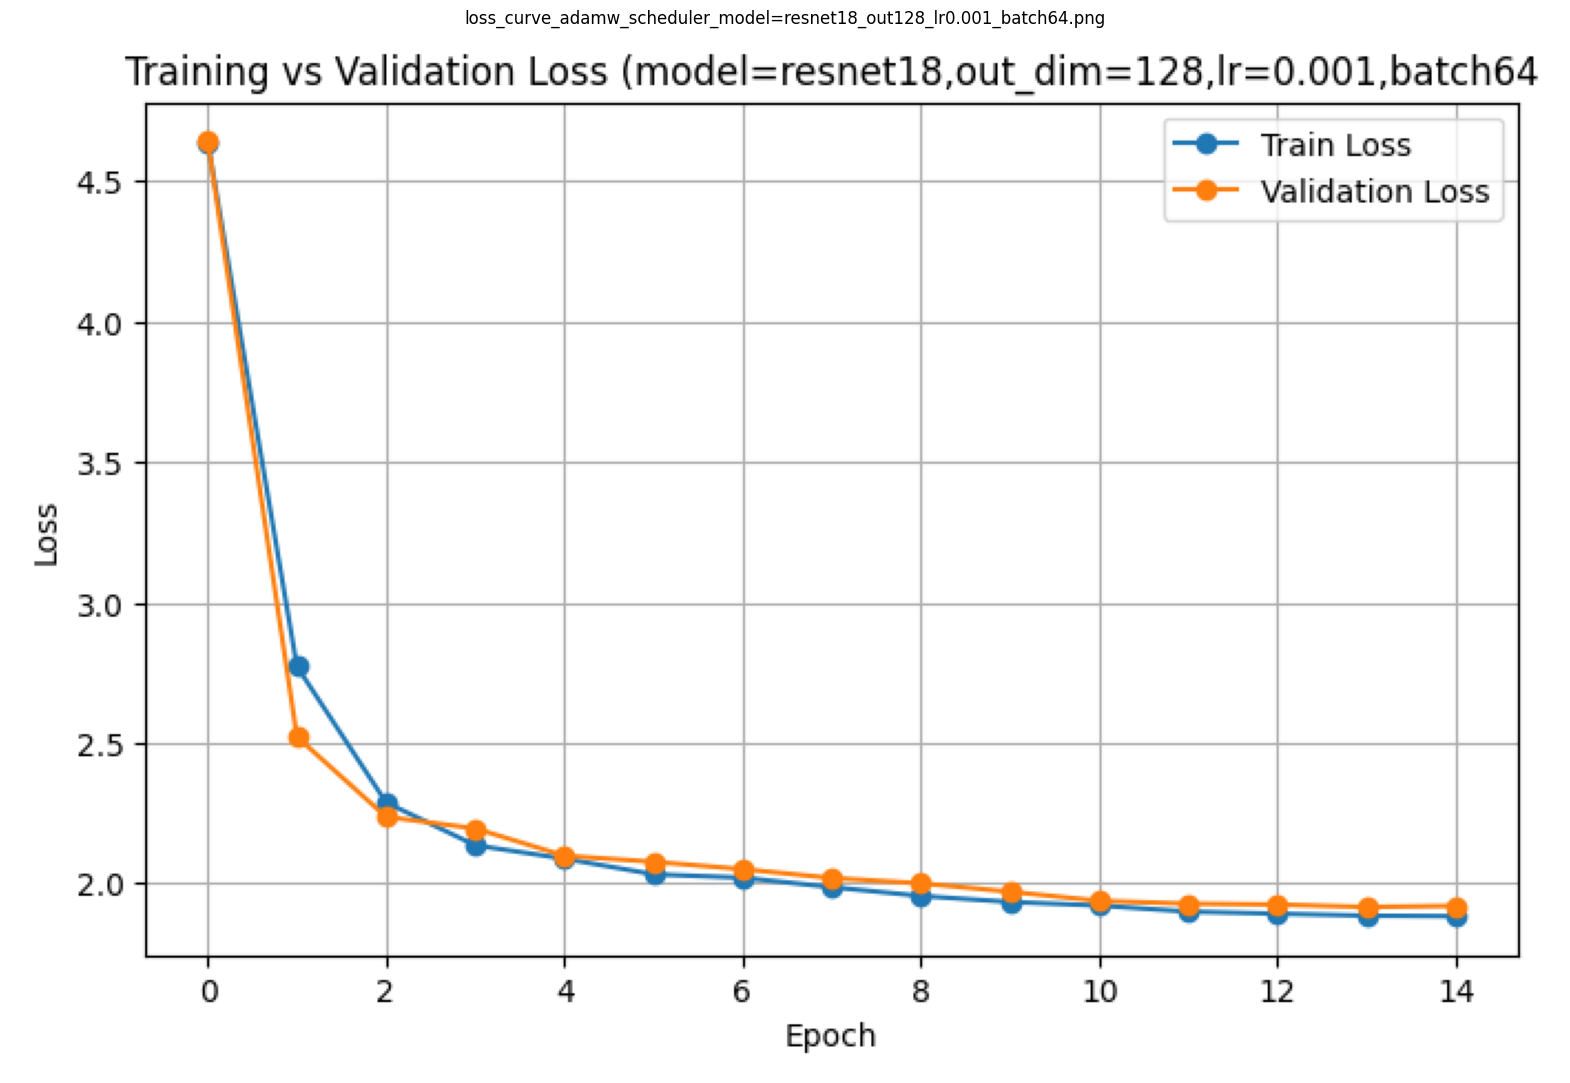

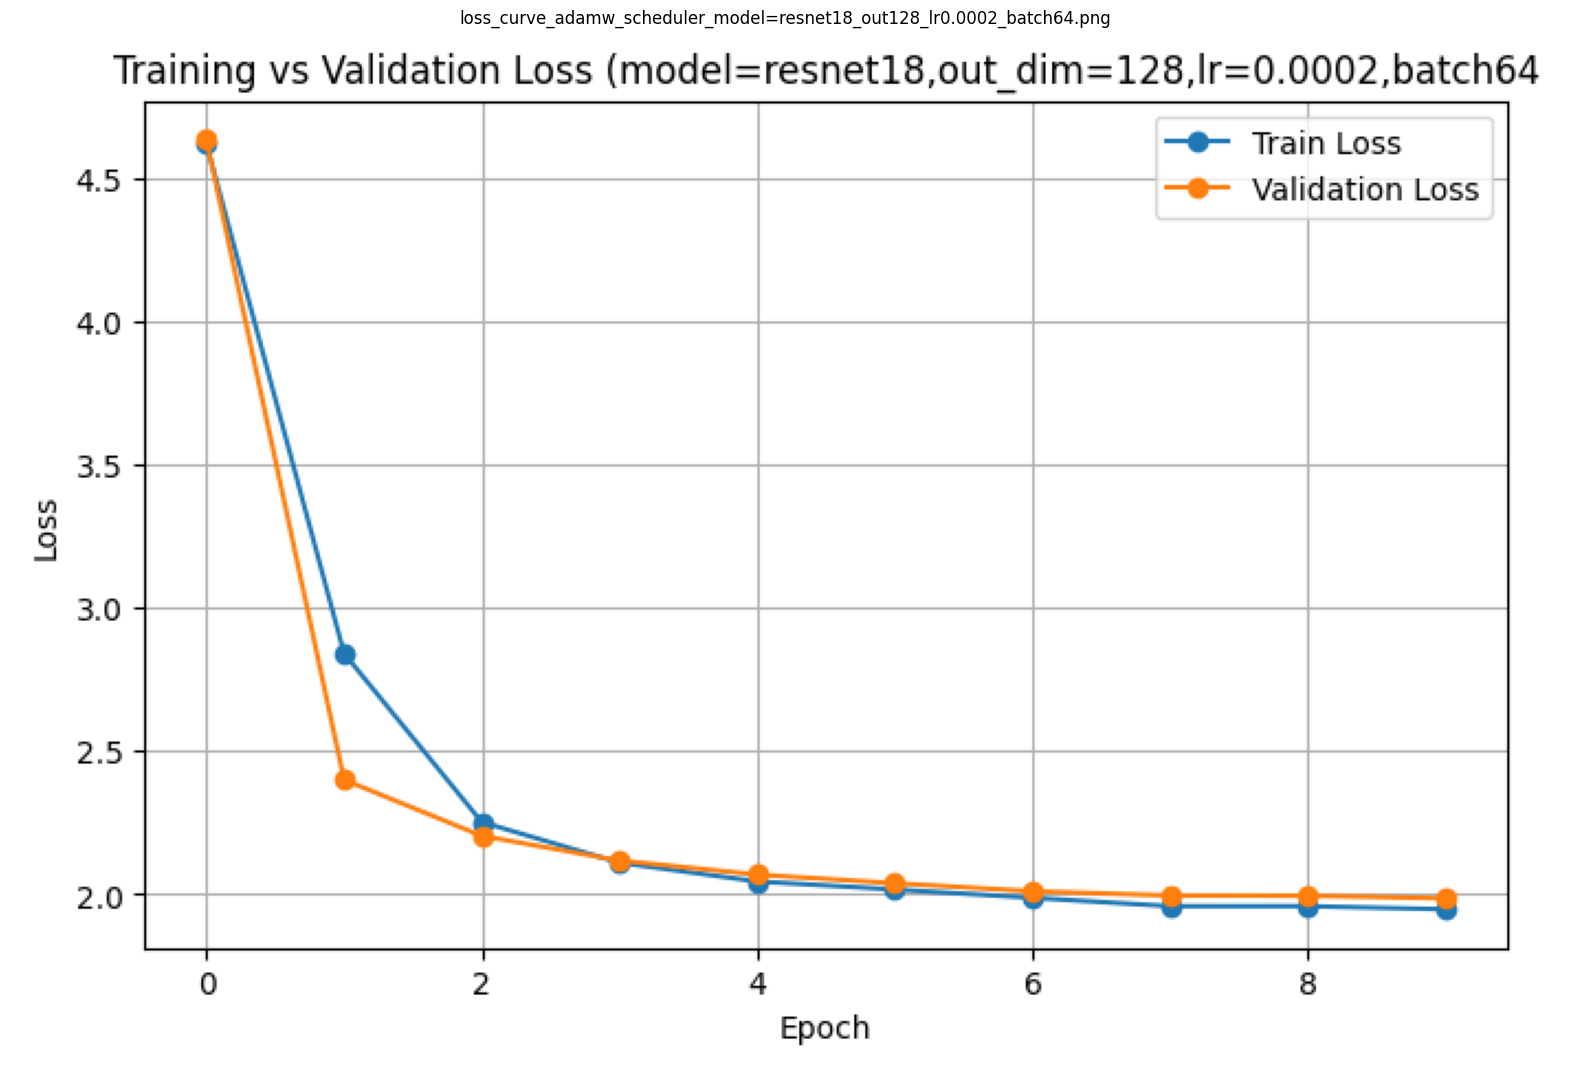

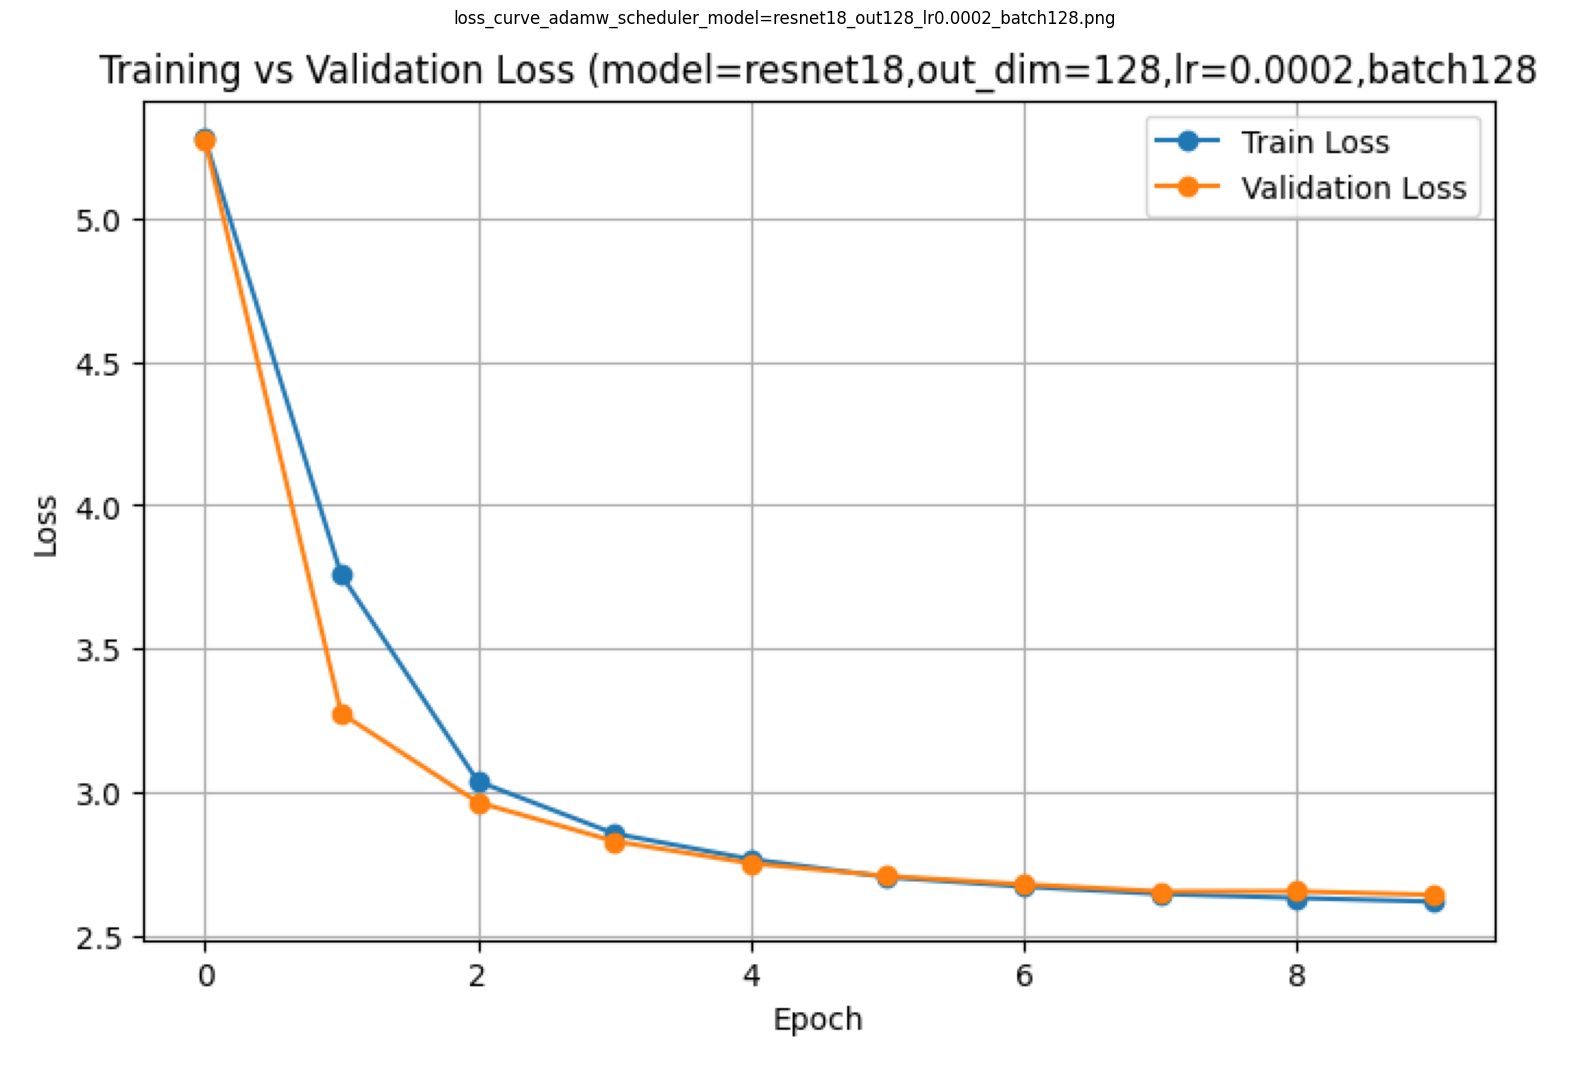

In [ ]:


images = ["loss_curve_adamw_scheduler_model=resnet18_out128_lr0.001_batch64.png",
        "loss_curve_adamw_scheduler_model=resnet18_out128_lr0.0002_batch64.png",
        "loss_curve_adamw_scheduler_model=resnet18_out128_lr0.0002_batch128.png"
            ]


for img_path in images:
    img = mpimg.imread(img_path)
    plt.figure(figsize=(20, 15))
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_path)
    plt.show()

###  Final Training Configuration

Given the results obtained from visualization, I made the following choices:

- **Base model:** `resnet18`  
- **Embedding dimension (`out_dim`):** `128`  
- **Temperature:** `0.6`  
- **Batch size:** `64`  
- **Learning rate (`lr`):** `0.001` (with scheduler decreasing down to `0.2 × lr`)  
- **Weight decay:** `5e-5`  
- **Epochs:** `20` — model weights are saved every 5 epochs as a backup.


In [ ]:
'''Once best hyperparameters identified, training on training+validation'''


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr=0.001
temperature=0.3
base_model='resnet18'
out_dim=128
weight_decay=5e-5
batch_size=64
num_epochs=15
adam_with_weight_decay=True
with_scheduler=True



model_f = ResNetSimCLR(base_model=base_model,out_dim=out_dim).to(device)


criterion = NTXentLoss(temperature=temperature)

if adam_with_weight_decay:
  optimizer = optim.AdamW(model_f.parameters(), lr=lr, weight_decay=weight_decay)
else:
  optimizer = optim.Adam(model_f.parameters(), lr=lr, weight_decay=weight_decay)

if with_scheduler:
  def warmup_cosine_scheduler(optimizer, num_epochs, warmup_ratio=0.1, lr_min_ratio=0.2):
      warmup_epochs = int(num_epochs * warmup_ratio)
      cosine_epochs = num_epochs - warmup_epochs

      def lr_lambda(epoch):
          if epoch < warmup_epochs:
              return epoch / warmup_epochs
          else:
              progress = (epoch - warmup_epochs) / cosine_epochs
              cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
              return lr_min_ratio + (1 - lr_min_ratio) * cosine_decay

      return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

  scheduler = warmup_cosine_scheduler(optimizer, num_epochs=num_epochs)


full_dataset = torch.utils.data.ConcatDataset([train_set, validation_set])
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True,num_workers=4,pin_memory=True,persistent_workers=True)

for epoch in range(num_epochs):
    model_f.train()
    running_loss = 0.0
    for images_T1, images_T2 in full_loader:
        images_T1, images_T2 = images_T1.to(device), images_T2.to(device)
        outputs_T1 = model_f(images_T1)
        outputs_T2 = model_f(images_T2)
        loss = criterion(outputs_T1, outputs_T2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if with_scheduler:
      scheduler.step()
    print(f"Final training loss epoch {epoch}: {running_loss/len(full_loader):.4f}")
    checkpoint_path = f"final_model_epoch{epoch+1}_val{avg_val_loss:.4f}.pth"
    if epoch%5==0:
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model_f.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict() if with_scheduler else None,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
        }, checkpoint_path)
        print(f"💾 Saved checkpoint: {checkpoint_path}")

if with_scheduler:
  if adam_with_weight_decay:
    filename = f"final_weights_adamw_scheduler_model={base_model}_out{out_dim}_batch{batch_size}_temperature{temp}_lr{lr}.png"
  else:
    filename = f"final_weights_scheduler_model={base_model}_out{out_dim}_batch{batch_size}_temperature{temp}_lr{lr}.png"
else:
  if adam_with_weight_decay:
    filename = f"final_weights_adamw_model={base_model}_out{out_dim}_batch{batch_size}_temperature{temp}_lr{lr}.png"
  else:
    filename = f"final_weights_model={base_model}_out{out_dim}_batch{batch_size}_temperature{temp}_lr{lr}.png"
torch.save(model_f.state_dict(), filename)

### Model Used for Testing

Below is the code to directly loads the weights of the model I used for testing.
The projection head is removed for inference, keeping only the backbone as the feature extractor.


In [43]:
reference_extractor = ResNetSimCLR(base_model=base_model,out_dim=out_dim).to(device)
reference_extractor.backbone.fc = nn.Identity()  

feature_extractor = ResNetSimCLR(base_model=base_model,out_dim=out_dim).to(device)
weights_file="final_weights_epoch15.pth"
ckpt = torch.load(weights_file, map_location='cpu')
feature_extractor.load_state_dict(ckpt["model_state_dict"], strict=True)
feature_extractor.backbone.fc = nn.Identity()

/var/folders/t9/q84x_b1n3xjgf7jpkdvlr4n00000gn/T/ipykernel_40693/2903975256.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(weights_file, map_location=

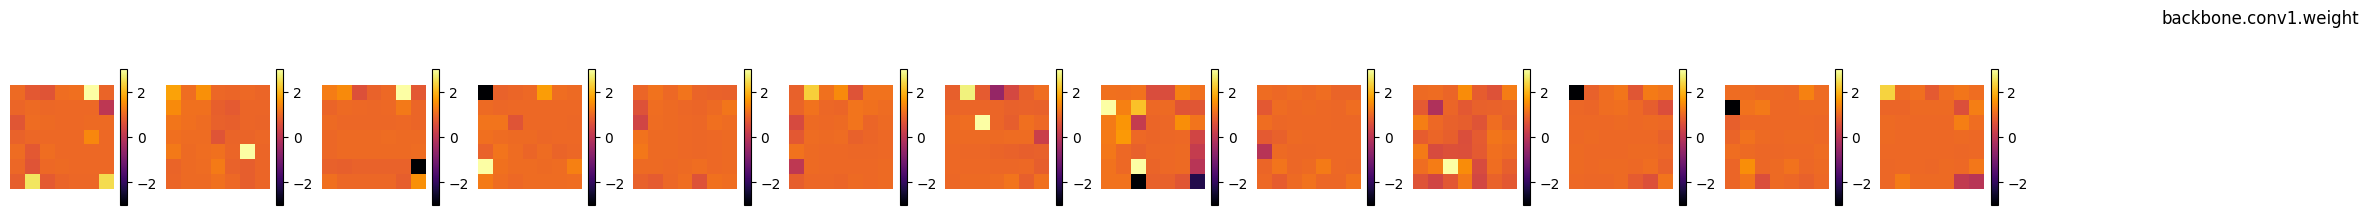

[SKIP] 1D layer: backbone.bn1.weight
[SKIP] 1D layer: backbone.bn1.bias


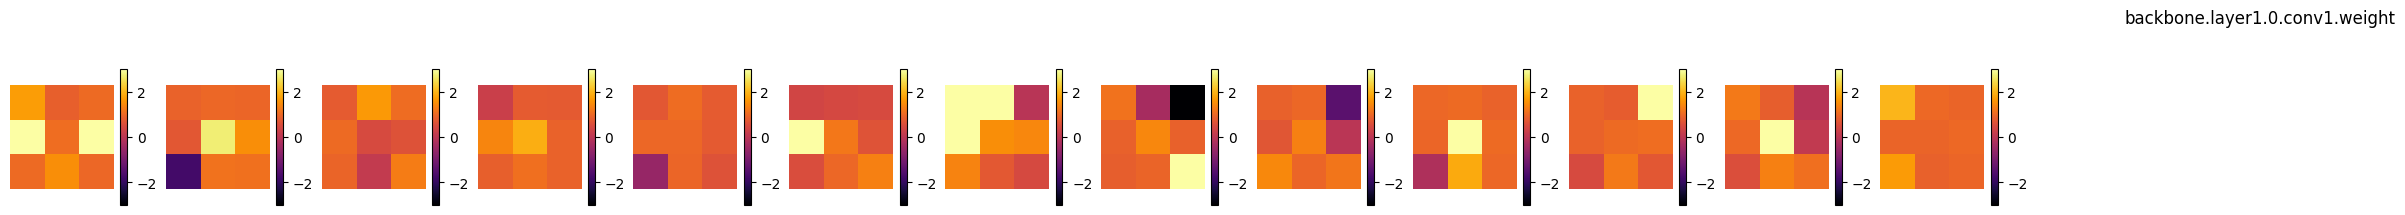

[SKIP] 1D layer: backbone.layer1.0.bn1.weight
[SKIP] 1D layer: backbone.layer1.0.bn1.bias


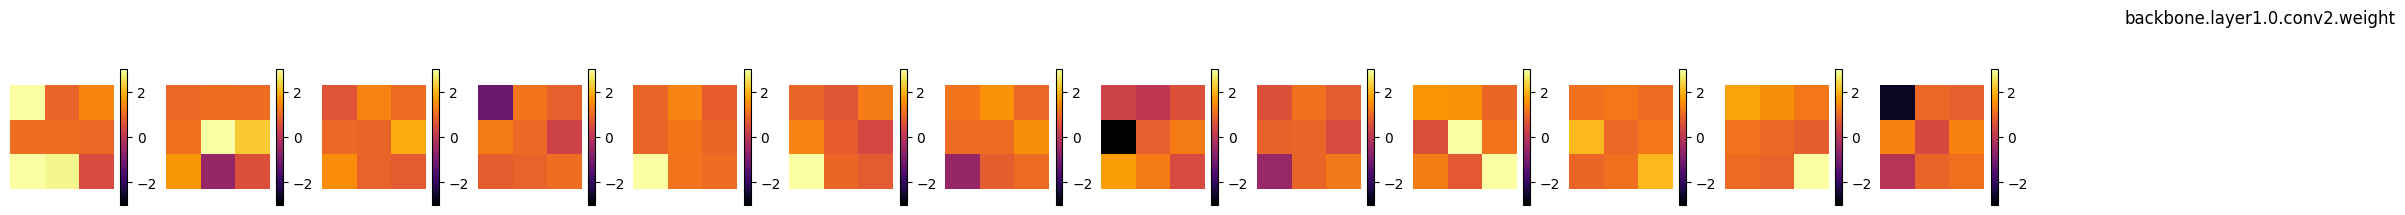

[SKIP] 1D layer: backbone.layer1.0.bn2.weight
[SKIP] 1D layer: backbone.layer1.0.bn2.bias


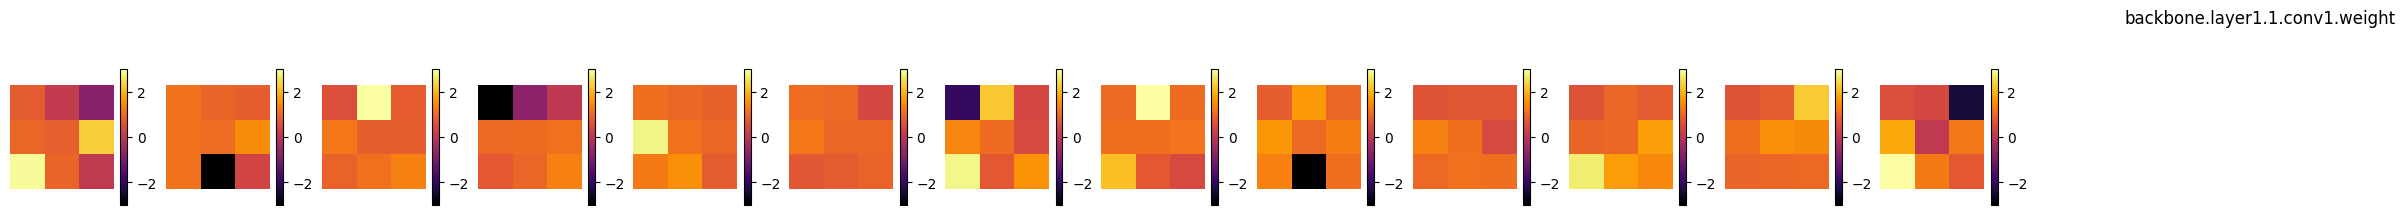

[SKIP] 1D layer: backbone.layer1.1.bn1.weight
[SKIP] 1D layer: backbone.layer1.1.bn1.bias


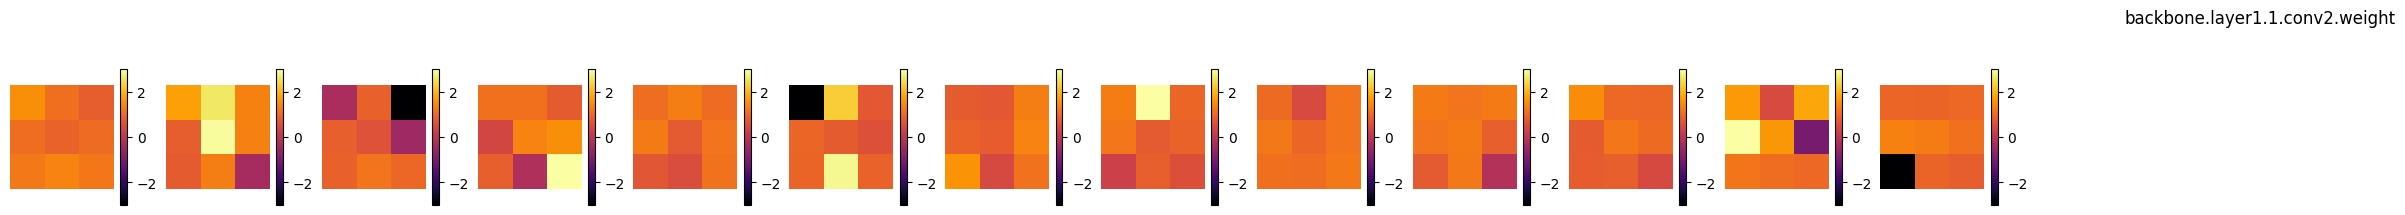

[SKIP] 1D layer: backbone.layer1.1.bn2.weight
[SKIP] 1D layer: backbone.layer1.1.bn2.bias


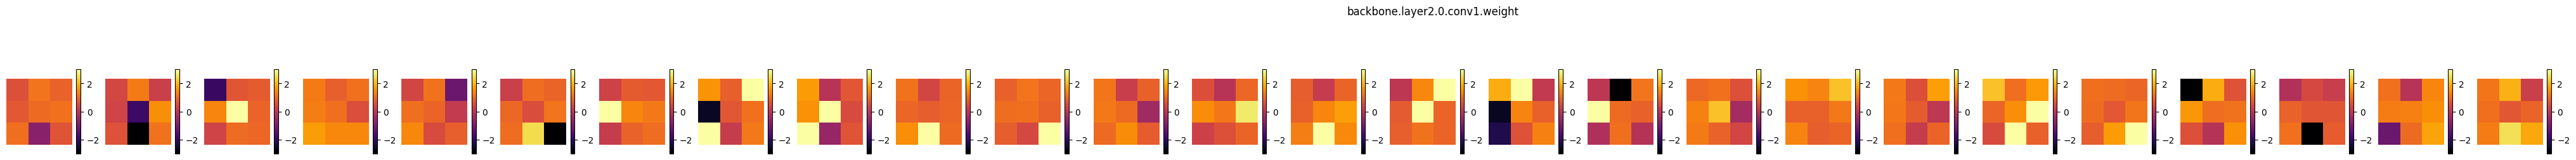

[SKIP] 1D layer: backbone.layer2.0.bn1.weight
[SKIP] 1D layer: backbone.layer2.0.bn1.bias


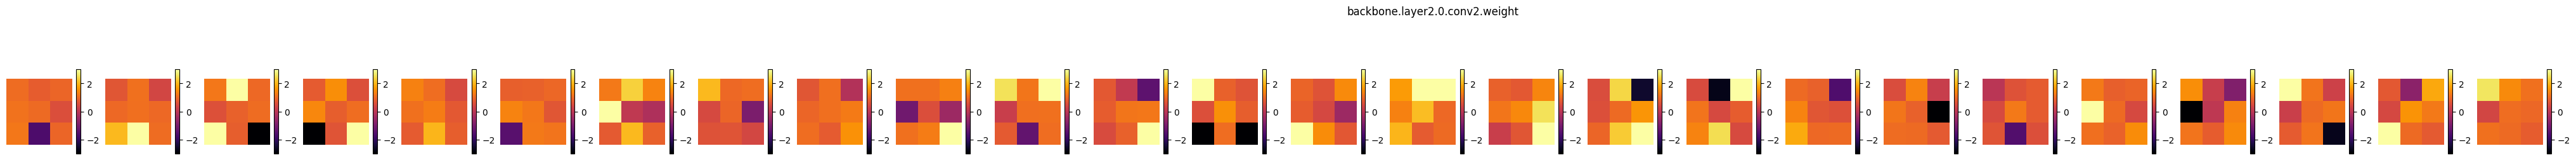

[SKIP] 1D layer: backbone.layer2.0.bn2.weight
[SKIP] 1D layer: backbone.layer2.0.bn2.bias


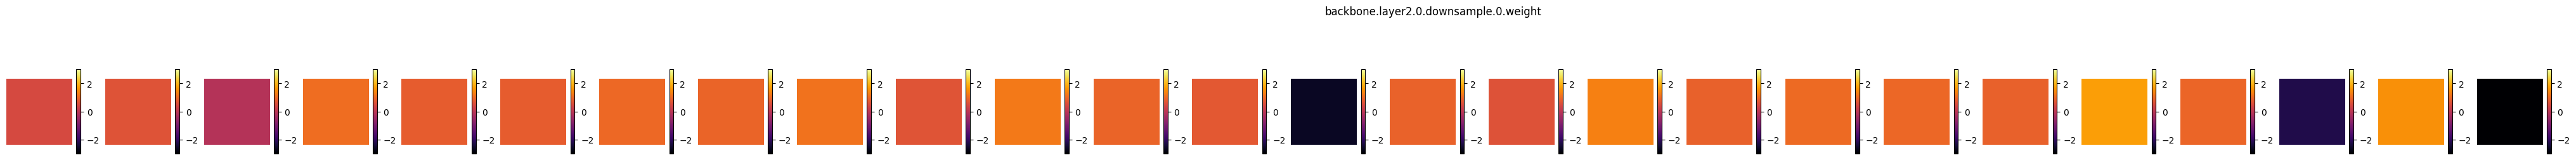

[SKIP] 1D layer: backbone.layer2.0.downsample.1.weight
[SKIP] 1D layer: backbone.layer2.0.downsample.1.bias


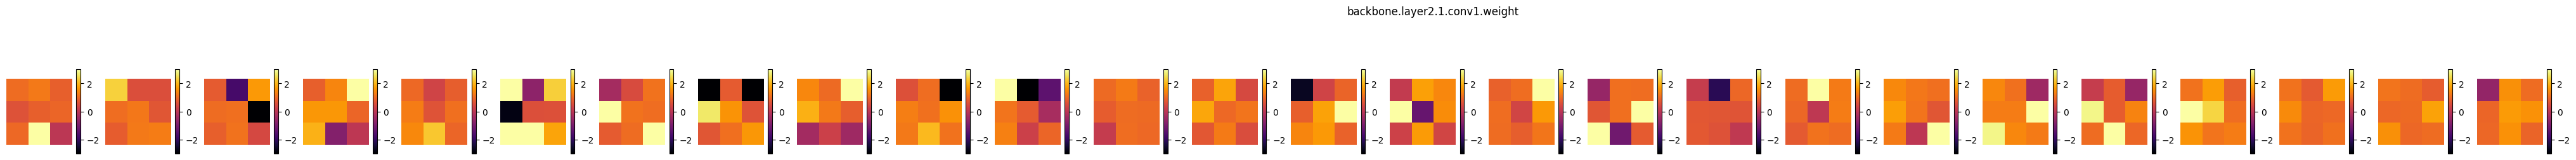

[SKIP] 1D layer: backbone.layer2.1.bn1.weight
[SKIP] 1D layer: backbone.layer2.1.bn1.bias


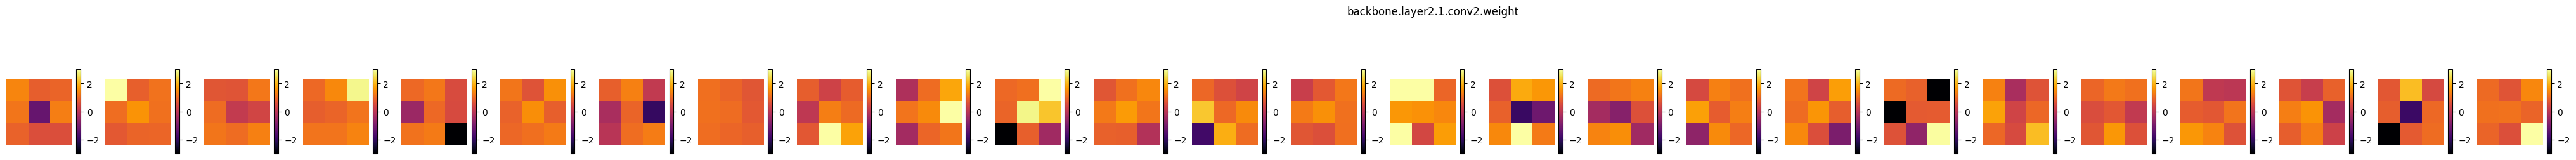

[SKIP] 1D layer: backbone.layer2.1.bn2.weight
[SKIP] 1D layer: backbone.layer2.1.bn2.bias


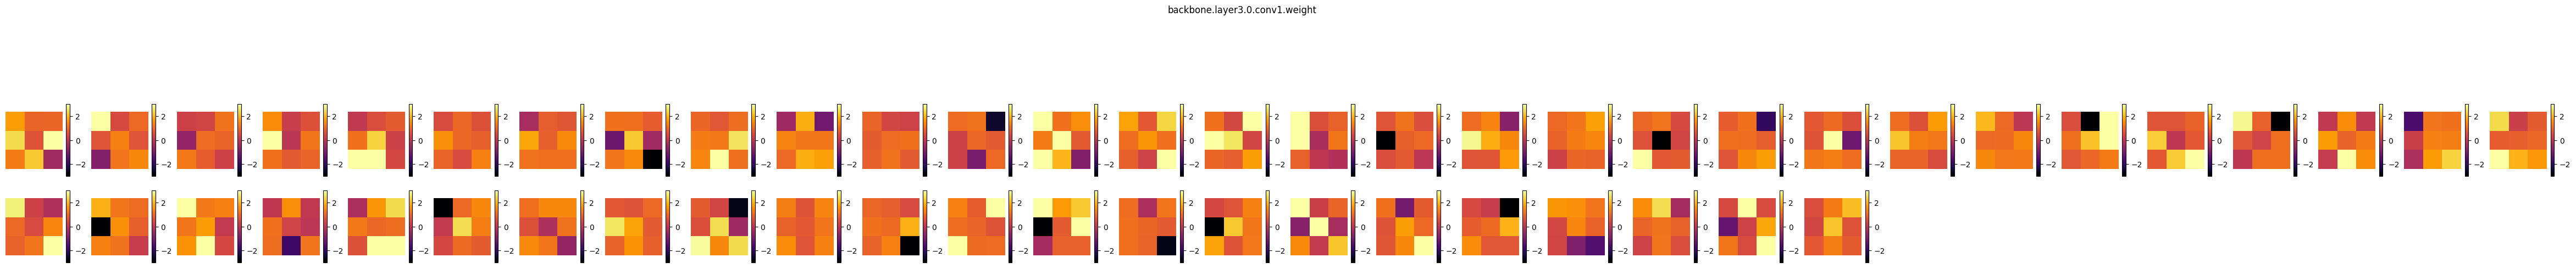

[SKIP] 1D layer: backbone.layer3.0.bn1.weight
[SKIP] 1D layer: backbone.layer3.0.bn1.bias


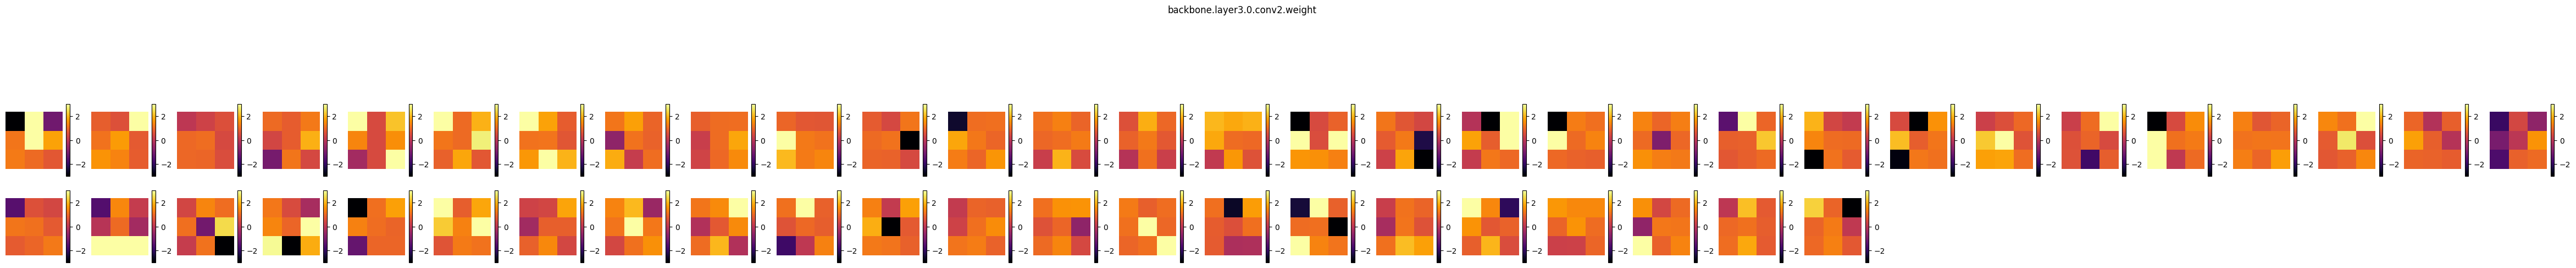

[SKIP] 1D layer: backbone.layer3.0.bn2.weight
[SKIP] 1D layer: backbone.layer3.0.bn2.bias


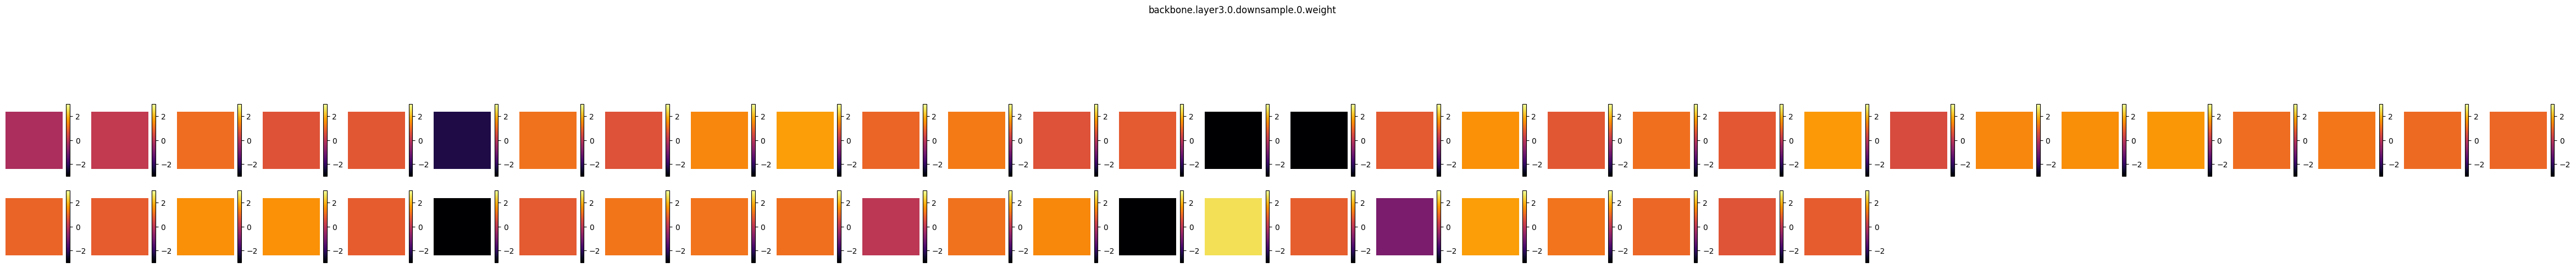

[SKIP] 1D layer: backbone.layer3.0.downsample.1.weight
[SKIP] 1D layer: backbone.layer3.0.downsample.1.bias


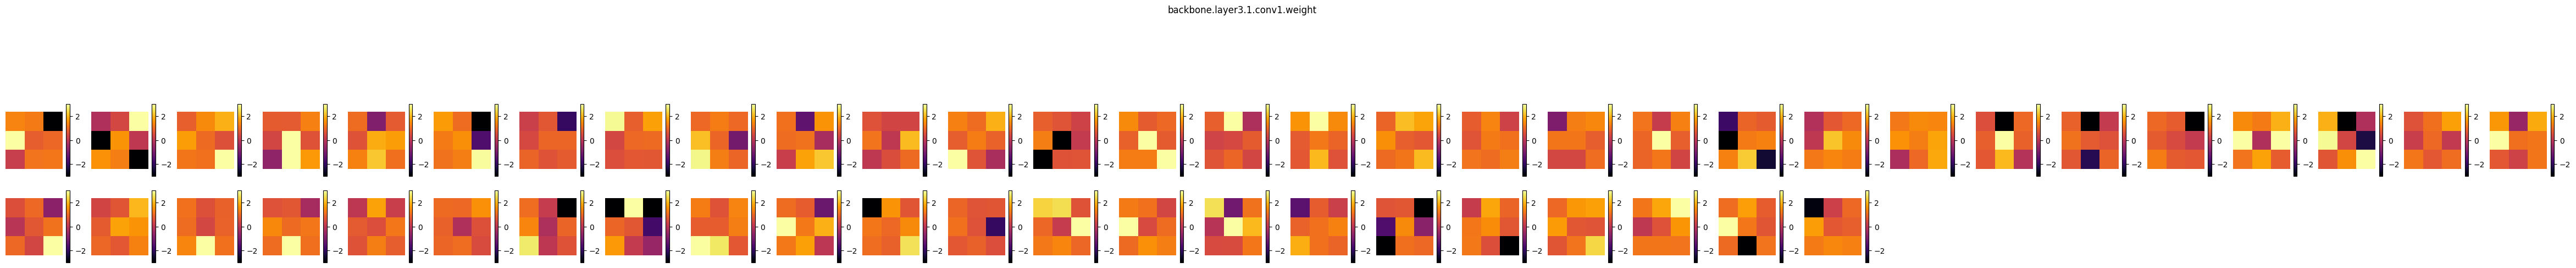

[SKIP] 1D layer: backbone.layer3.1.bn1.weight
[SKIP] 1D layer: backbone.layer3.1.bn1.bias


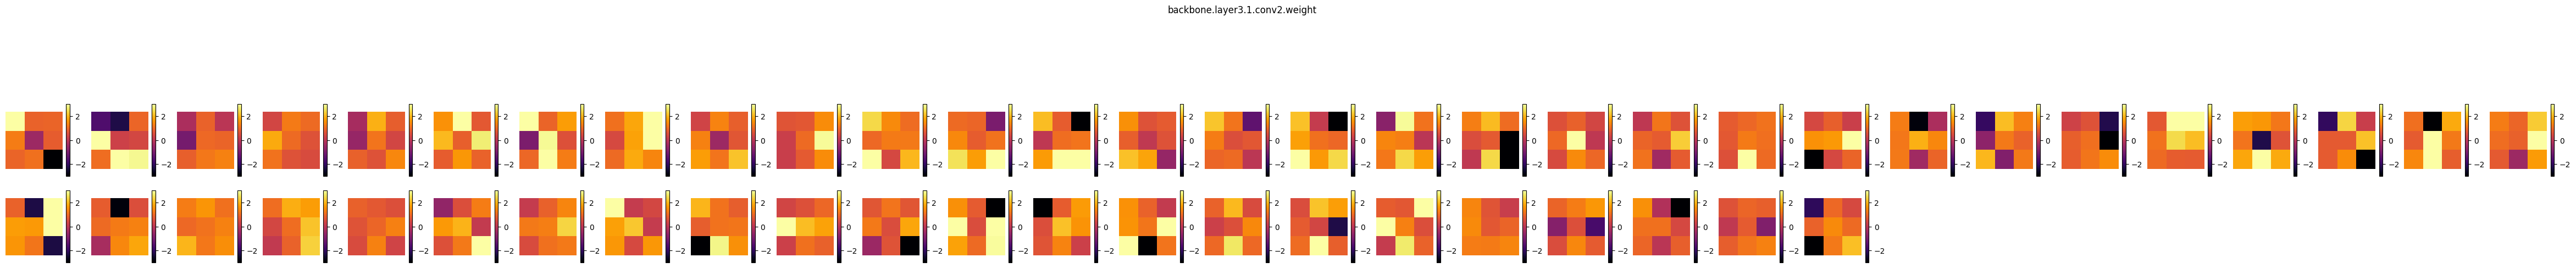

[SKIP] 1D layer: backbone.layer3.1.bn2.weight
[SKIP] 1D layer: backbone.layer3.1.bn2.bias


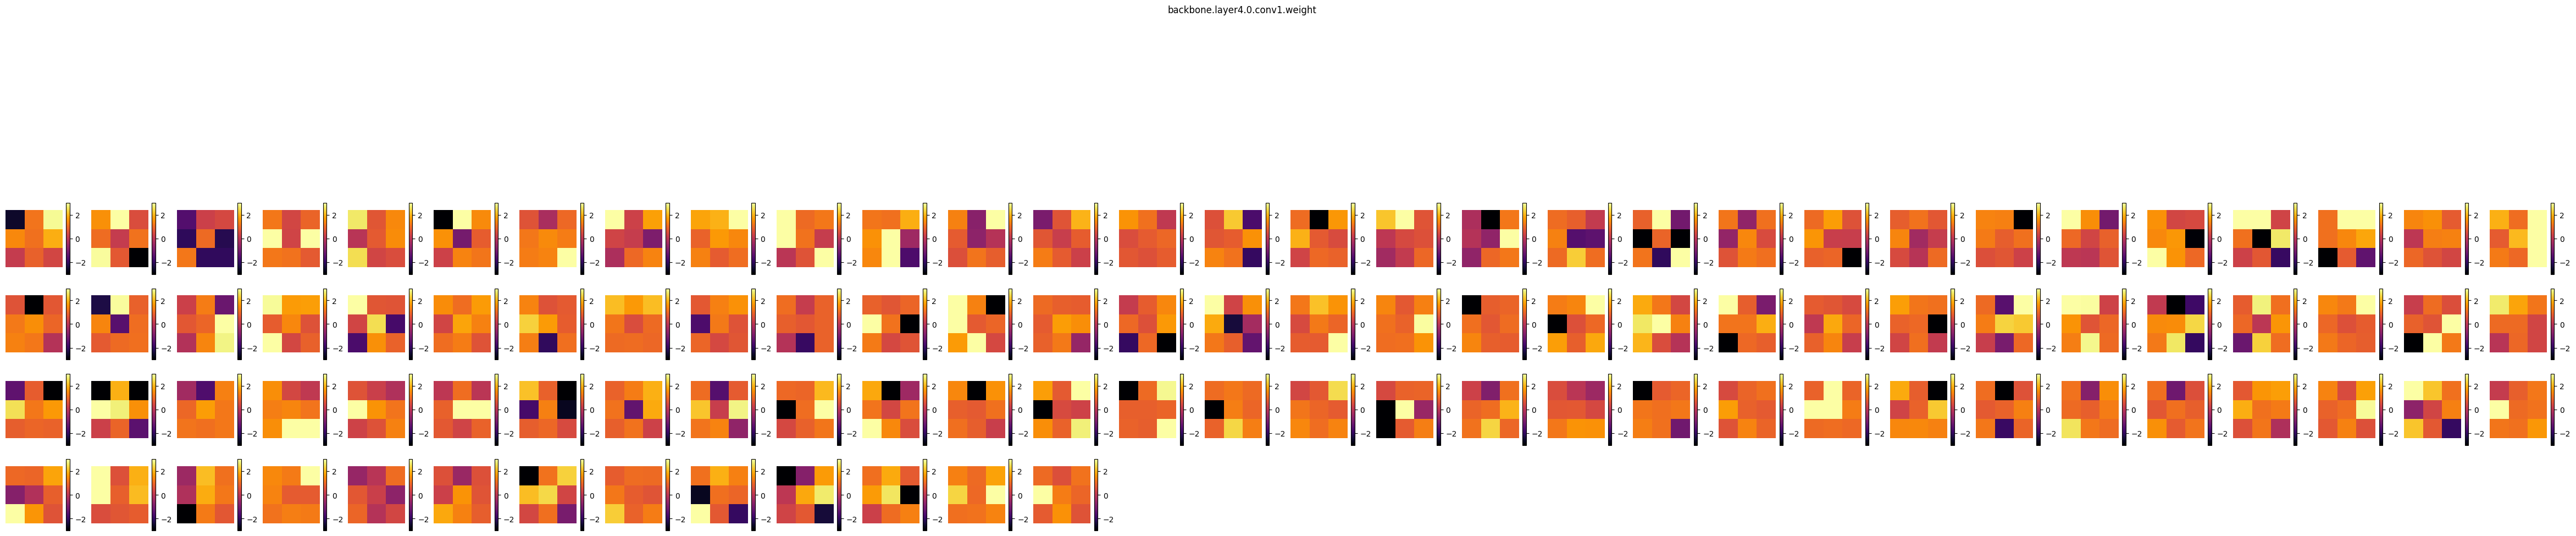

[SKIP] 1D layer: backbone.layer4.0.bn1.weight
[SKIP] 1D layer: backbone.layer4.0.bn1.bias


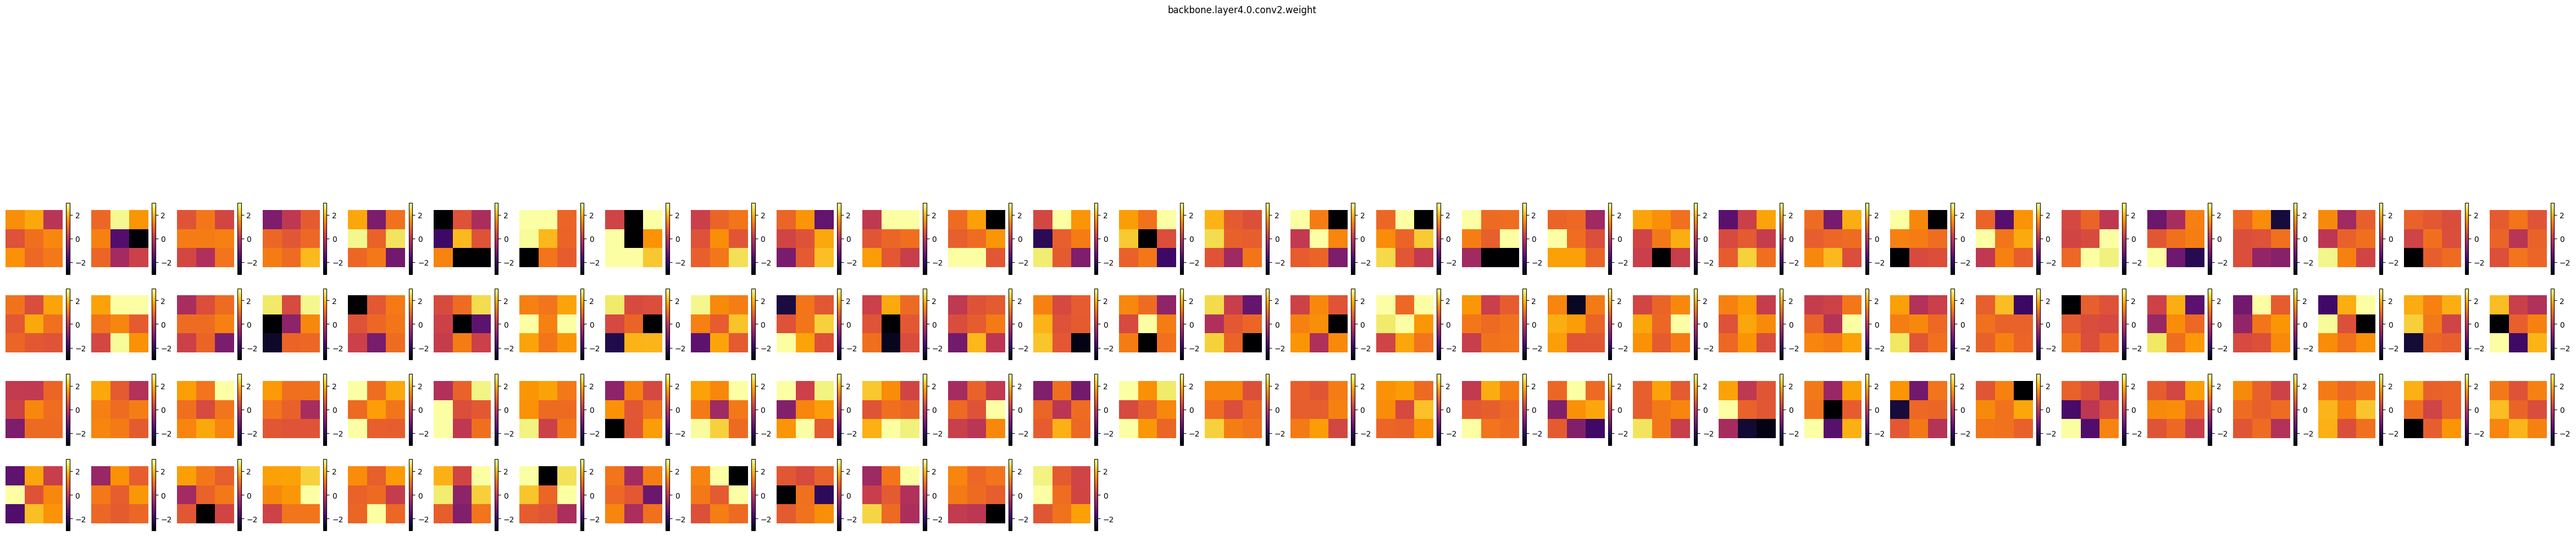

[SKIP] 1D layer: backbone.layer4.0.bn2.weight
[SKIP] 1D layer: backbone.layer4.0.bn2.bias


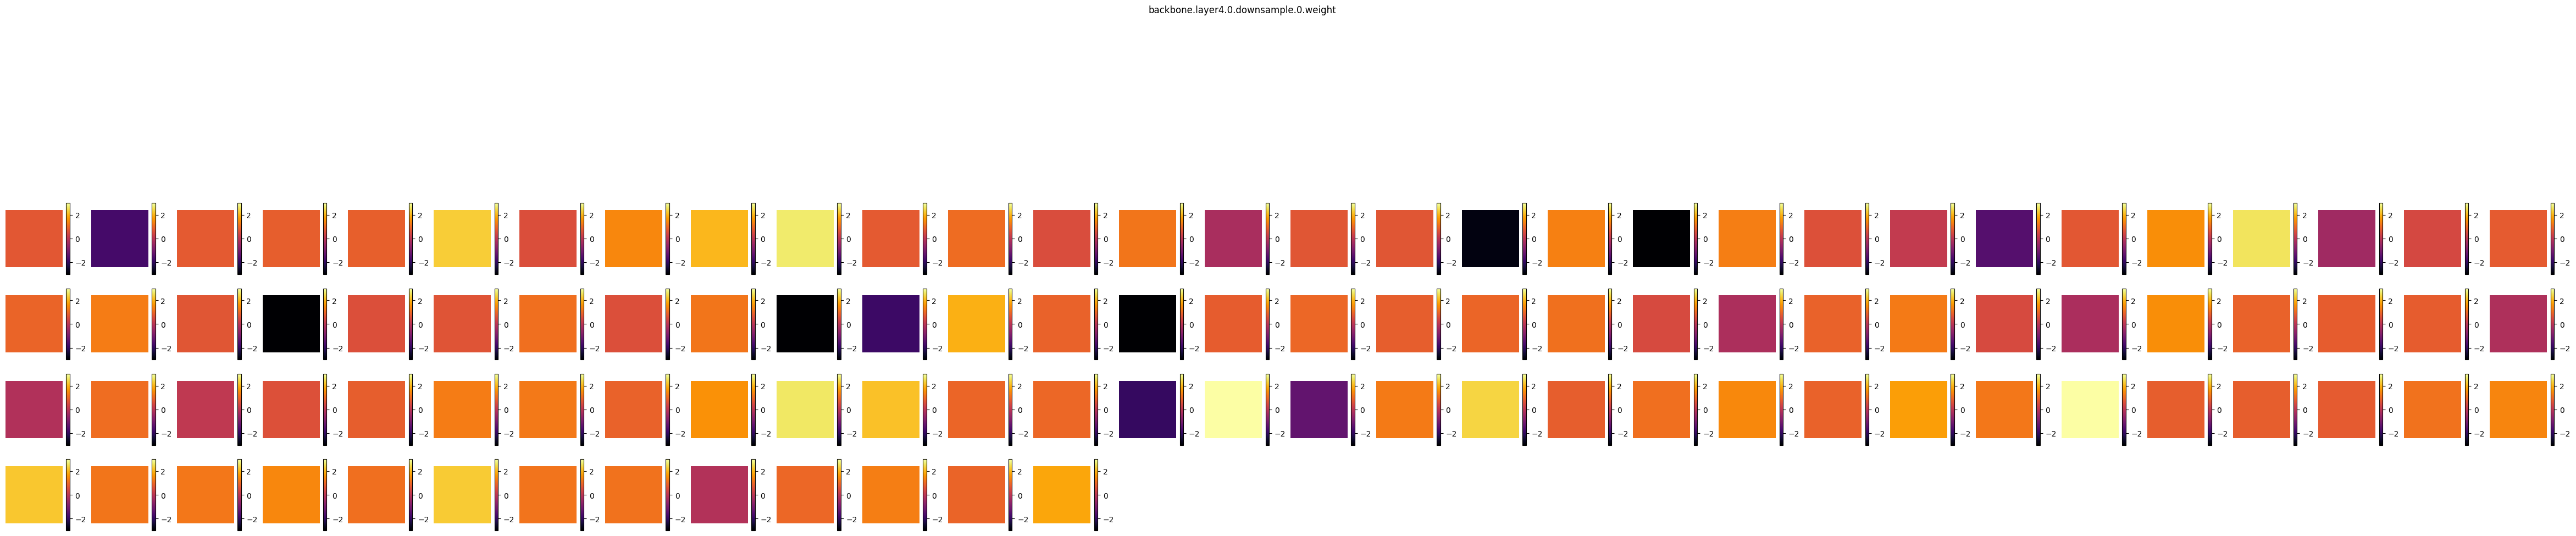

[SKIP] 1D layer: backbone.layer4.0.downsample.1.weight
[SKIP] 1D layer: backbone.layer4.0.downsample.1.bias


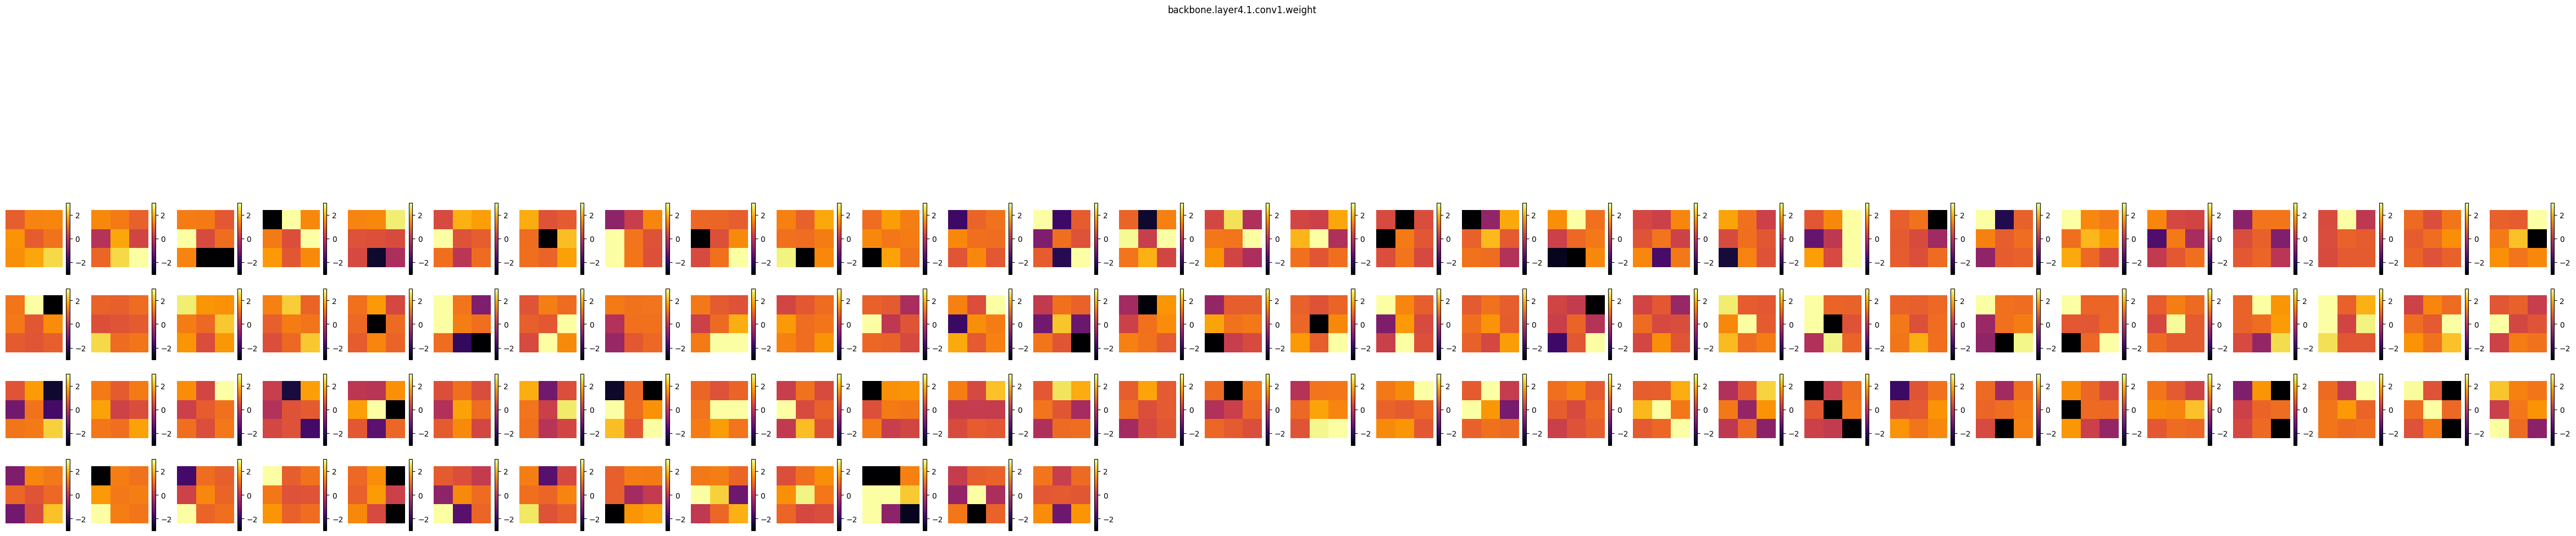

[SKIP] 1D layer: backbone.layer4.1.bn1.weight
[SKIP] 1D layer: backbone.layer4.1.bn1.bias


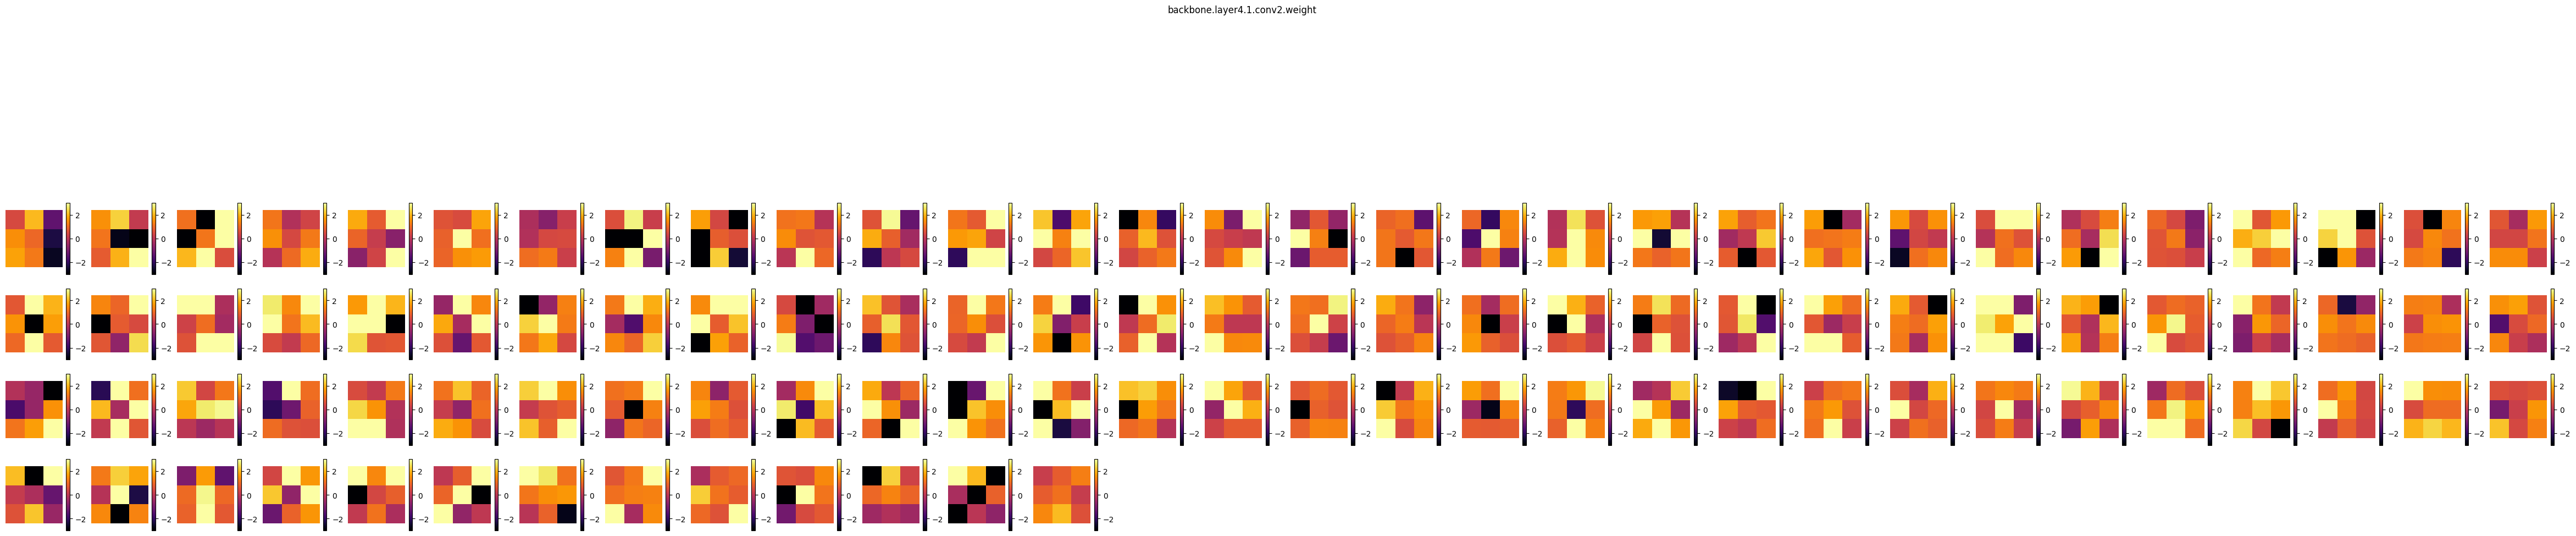

[SKIP] 1D layer: backbone.layer4.1.bn2.weight
[SKIP] 1D layer: backbone.layer4.1.bn2.bias


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

params_before = dict(reference_extractor.named_parameters())
params_after  = dict(feature_extractor.named_parameters())

for name, w_before in params_before.items():
    if name not in params_after:
        continue

    w_before = w_before.detach().cpu().numpy()
    w_after  = params_after[name].detach().cpu().numpy()

    if w_before.shape != w_after.shape:
        continue

    # Calcul du rapport des poids avant / après
    ratio = w_after / w_before

    # --- 1D → impossible à afficher
    if ratio.ndim == 1:
        print(f"[SKIP] 1D layer: {name}")
        continue

    # --- 2D → direct
    if ratio.ndim == 2:
        print("2DDDDDf")

        plt.figure(figsize=(5,4))
        im = plt.imshow(ratio, cmap="inferno")
        plt.colorbar(im)  # Afficher l'échelle de couleur
        plt.title(f"{name}")
        plt.show()
        continue

    # --- 3D → convolution : plusieurs filtres
    if ratio.ndim == 3:
        print("333DDDDDf")
        C, H, W = ratio.shape
        cols = 8
        rows = int(np.ceil(C / cols))

        plt.figure(figsize=(cols*2, rows*2))
        for i in range(C):
            plt.subplot(rows, cols, i+1)
            im = plt.imshow(ratio[i], cmap="inferno")
            plt.axis("off")
            plt.colorbar(im)  # Afficher l'échelle de couleur pour chaque filtre
        plt.suptitle(f"{name}")
        plt.show()
        continue

    if ratio.ndim == 4:
        # Projection : moyenne sur les in_channels
        ratio2 = ratio.mean(axis=1)  # (out_channels, H, W)

        C, H, W = ratio2.shape
        cols = 30  # Nombre de colonnes
        rows = int(np.ceil(C / cols))  # Nombre de lignes ajusté

        # Fixer l'échelle des valeurs entre -3 et 3
        vmin, vmax = -3, 3

        plt.figure(figsize=(cols * 2, rows * 2))

        idx = 1
        for i in range(C):
            if i % 5 == 0:  
                plt.subplot(rows, cols, idx) 
                im = plt.imshow(ratio2[i], cmap="inferno", vmin=vmin, vmax=vmax)  # Fixe l'échelle pour toutes les images
                plt.axis("off")
                plt.colorbar(im)  # Afficher la colorbar avec l'échelle définie
                idx += 1  # Incrémenter l'indice pour chaque filtre

        plt.suptitle(f"{name}")
        plt.show()
        continue

###  One-Shot Evaluation Protocol

- We take the cropped images from the testing set.  
- All images are embedded using the trained model.  
- For each class, we randomly select one vector within that class as the reference (one-shot).  
  - Using the average vector per class could yield better accuracy, but in real conditions, the user would only provide a single random example per label.  


- We identify **40 classes** among **430 examples**.  
- Finally, we compare the **average accuracy** with the one obtained using the **ResNet backbone extractor**.


In [69]:
class YoloCroppedEvaluator:
    def __init__(self, model, root_dir, device="cuda"):
        self.model = model.to(device)
        self.model.eval()
        self.root_dir = root_dir
        self.cropped_dir = os.path.join(root_dir, "images_cropped")
        self.label_dir = os.path.join(root_dir, "labels")
        self.device = device
        self.transform = conversion_transform

    def load_crops(self):
        crops, class_ids = [], []
        class_count = {}

        for fname in tqdm(os.listdir(self.cropped_dir), desc="Loading cropped images"):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            img_path = os.path.join(self.cropped_dir, fname)
            cls = int(fname.split("cls")[-1].split(".")[0])
            img = Image.open(img_path).convert("RGB")

            crops.append(img)
            class_ids.append(cls)

            class_count[cls] = class_count.get(cls, 0) + 1

        print("\n📊 Class distribution in images_cropped/:")
        for cls in sorted(class_count.keys()):
            print(f"  Class {cls:>3}  →  {class_count[cls]} images")

        print(f"\nTotal classes: {len(class_count)}")
        print(f"Total images : {len(class_ids)}\n")

        return crops, class_ids

    def compute_embeddings(self, crops):
        tensors = torch.stack([self.transform(img) for img in crops]).to(self.device)
        with torch.no_grad():
            feats = self.model(tensors)
            feats = F.normalize(feats, dim=1)
        return feats

    def build_reference_bank(self, feats, class_ids):
        class_to_indices = {}
        for i, cls in enumerate(class_ids):
            class_to_indices.setdefault(cls, []).append(i)

        refs = {}
        for cls, idxs in class_to_indices.items():
            ref_idx = random.choice(idxs)
            refs[cls] = feats[ref_idx]

        return refs, class_to_indices

    def classify_once(self, feats, class_ids):
        refs, class_to_indices = self.build_reference_bank(feats, class_ids)
        ref_mat = torch.stack(list(refs.values()))
        ref_classes = list(refs.keys())

        sims = feats @ ref_mat.T
        preds = sims.argmax(dim=1)
        predicted_classes = [ref_classes[i] for i in preds.cpu().numpy()]

        correct = sum([p == gt for p, gt in zip(predicted_classes, class_ids)])
        acc = correct / len(class_ids)
        return acc

    def evaluate_average_accuracy(self,crops,class_ids,feats,n_runs=20):
        accuracies = []
        for i in range(n_runs):
            acc = self.classify_once(feats, class_ids)
            accuracies.append(acc)
            print(f"Run {i+1}/{n_runs}: accuracy = {acc*100:.2f}%")

        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        print(f"\n✅ Mean accuracy over {n_runs} runs: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")

        return mean_acc, std_acc

In [70]:
evaluator = YoloCroppedEvaluator(feature_extractor, root_dir="./firefighting-device-detection/test", device=device)
crops, class_ids=evaluator.load_crops()
feats = evaluator.compute_embeddings(crops)
plot_tsne(feats, class_ids)
mean_acc, std_acc = evaluator.evaluate_average_accuracy(crops = crops, class_ids=class_ids,feats=feats,n_runs=30)

Loading cropped images: 100%|██████████| 424/424 [00:00<00:00, 3463.71it/s]



📊 Class distribution in images_cropped/:
  Class   0  →  149 images
  Class   1  →  17 images
  Class   2  →  3 images
  Class   3  →  25 images
  Class   4  →  25 images
  Class   5  →  4 images
  Class   7  →  5 images
  Class   8  →  5 images
  Class   9  →  1 images
  Class  11  →  3 images
  Class  14  →  9 images
  Class  15  →  59 images
  Class  16  →  19 images
  Class  17  →  5 images
  Class  19  →  1 images
  Class  21  →  22 images
  Class  22  →  7 images
  Class  23  →  3 images
  Class  24  →  16 images
  Class  25  →  13 images
  Class  27  →  5 images
  Class  28  →  9 images
  Class  29  →  3 images
  Class  31  →  1 images
  Class  32  →  2 images
  Class  33  →  2 images
  Class  34  →  4 images
  Class  37  →  1 images
  Class  39  →  4 images
  Class  40  →  2 images

Total classes: 30
Total images : 424

Run 1/30: accuracy = 60.14%
Run 2/30: accuracy = 58.25%
Run 3/30: accuracy = 66.27%
Run 4/30: accuracy = 67.69%
Run 5/30: accuracy = 59.20%
Run 6/30: accuracy 

In [48]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(feats, class_ids, perplexity=30, n_iter=1000):
    """
    feats: torch.Tensor of shape (N, D)
    class_ids: list or array of length N
    """

    # Convert to numpy
    X = feats.cpu().numpy()
    y = np.array(class_ids)

    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=n_iter,
        learning_rate="auto",
        init="random"
    )
    X_2d = tsne.fit_transform(X)

    # Plot with per-class colors
    plt.figure(figsize=(10, 8))

    unique_classes = np.unique(y)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classes)))

    for cls, color in zip(unique_classes, colors):
        idx = (y == cls)
        plt.scatter(
            X_2d[idx, 0],
            X_2d[idx, 1],
            c=[color],
            s=15,
            alpha=0.8,
            label=str(cls)
        )

    plt.title("t-SNE of Symbol Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")

    plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


Loading cropped images: 100%|██████████| 424/424 [00:00<00:00, 9179.28it/s]



📊 Class distribution in images_cropped/:
  Class   0  →  149 images
  Class   1  →  17 images
  Class   2  →  3 images
  Class   3  →  25 images
  Class   4  →  25 images
  Class   5  →  4 images
  Class   7  →  5 images
  Class   8  →  5 images
  Class   9  →  1 images
  Class  11  →  3 images
  Class  14  →  9 images
  Class  15  →  59 images
  Class  16  →  19 images
  Class  17  →  5 images
  Class  19  →  1 images
  Class  21  →  22 images
  Class  22  →  7 images
  Class  23  →  3 images
  Class  24  →  16 images
  Class  25  →  13 images
  Class  27  →  5 images
  Class  28  →  9 images
  Class  29  →  3 images
  Class  31  →  1 images
  Class  32  →  2 images
  Class  33  →  2 images
  Class  34  →  4 images
  Class  37  →  1 images
  Class  39  →  4 images
  Class  40  →  2 images

Total classes: 30
Total images : 424



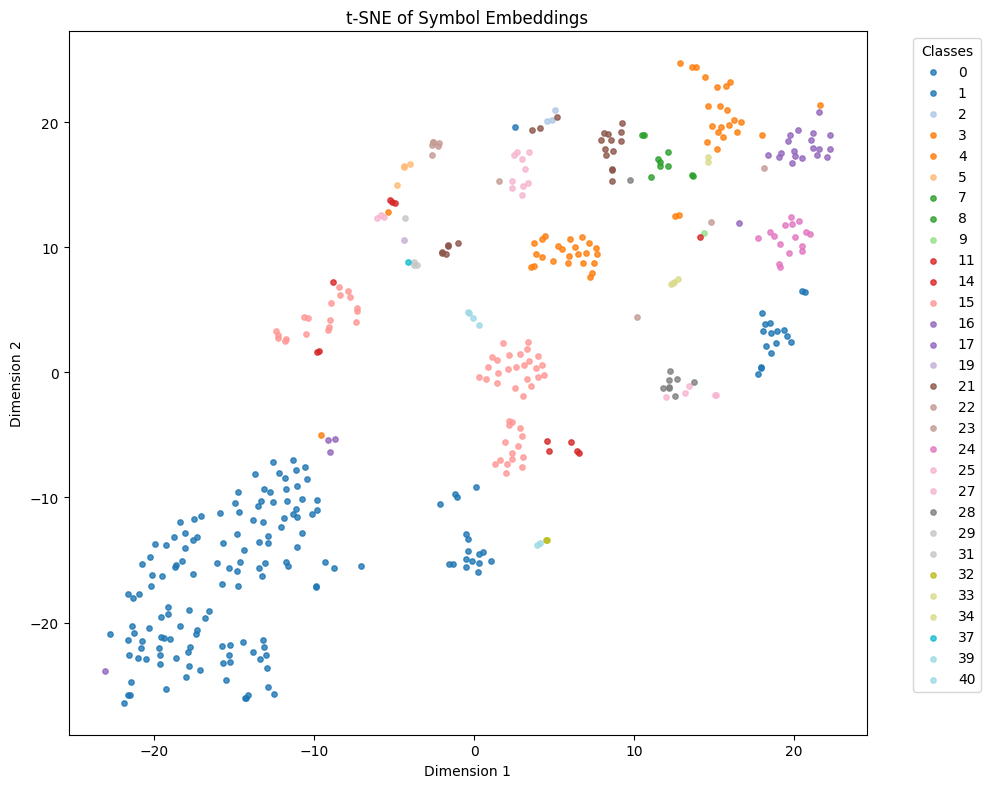

In [49]:
crops, class_ids = evaluator.load_crops()
feats = evaluator.compute_embeddings(crops)
plot_tsne(feats, class_ids)

In [ ]:
valid_evaluator = YoloCroppedEvaluator(feature_extractor, root_dir="./firefighting-device-detection/valid", device=device)
mean_acc, std_acc = valid_evaluator.evaluate_average_accuracy(n_runs=30)

Loading cropped images: 100%|██████████| 755/755 [00:00<00:00, 11548.95it/s]


Run 1/30: accuracy = 73.51%
Run 2/30: accuracy = 75.10%
Run 3/30: accuracy = 71.39%
Run 4/30: accuracy = 67.95%
Run 5/30: accuracy = 69.40%
Run 6/30: accuracy = 65.17%
Run 7/30: accuracy = 71.66%
Run 8/30: accuracy = 55.76%
Run 9/30: accuracy = 65.96%
Run 10/30: accuracy = 65.96%
Run 11/30: accuracy = 77.09%
Run 12/30: accuracy = 74.30%
Run 13/30: accuracy = 71.79%
Run 14/30: accuracy = 67.95%
Run 15/30: accuracy = 69.67%
Run 16/30: accuracy = 69.54%
Run 17/30: accuracy = 69.40%
Run 18/30: accuracy = 68.21%
Run 19/30: accuracy = 63.31%
Run 20/30: accuracy = 72.58%
Run 21/30: accuracy = 67.28%
Run 22/30: accuracy = 68.21%
Run 23/30: accuracy = 71.26%
Run 24/30: accuracy = 71.92%
Run 25/30: accuracy = 67.81%
Run 26/30: accuracy = 59.74%
Run 27/30: accuracy = 71.66%
Run 28/30: accuracy = 64.11%
Run 29/30: accuracy = 74.70%
Run 30/30: accuracy = 60.40%

✅ Mean accuracy over 30 runs: 68.76% ± 4.72%


In [50]:
reference_evaluator = YoloCroppedEvaluator(reference_extractor, root_dir="./firefighting-device-detection/test", device=device)
mean_acc, std_acc = reference_evaluator.evaluate_average_accuracy(n_runs=30)

Loading cropped images: 100%|██████████| 424/424 [00:00<00:00, 10193.48it/s]



📊 Class distribution in images_cropped/:
  Class   0  →  149 images
  Class   1  →  17 images
  Class   2  →  3 images
  Class   3  →  25 images
  Class   4  →  25 images
  Class   5  →  4 images
  Class   7  →  5 images
  Class   8  →  5 images
  Class   9  →  1 images
  Class  11  →  3 images
  Class  14  →  9 images
  Class  15  →  59 images
  Class  16  →  19 images
  Class  17  →  5 images
  Class  19  →  1 images
  Class  21  →  22 images
  Class  22  →  7 images
  Class  23  →  3 images
  Class  24  →  16 images
  Class  25  →  13 images
  Class  27  →  5 images
  Class  28  →  9 images
  Class  29  →  3 images
  Class  31  →  1 images
  Class  32  →  2 images
  Class  33  →  2 images
  Class  34  →  4 images
  Class  37  →  1 images
  Class  39  →  4 images
  Class  40  →  2 images

Total classes: 30
Total images : 424

Run 1/30: accuracy = 60.85%
Run 2/30: accuracy = 66.27%
Run 3/30: accuracy = 69.81%
Run 4/30: accuracy = 69.81%
Run 5/30: accuracy = 70.52%
Run 6/30: accuracy 

Loading cropped images: 100%|██████████| 424/424 [00:00<00:00, 9093.43it/s]



📊 Class distribution in images_cropped/:
  Class   0  →  149 images
  Class   1  →  17 images
  Class   2  →  3 images
  Class   3  →  25 images
  Class   4  →  25 images
  Class   5  →  4 images
  Class   7  →  5 images
  Class   8  →  5 images
  Class   9  →  1 images
  Class  11  →  3 images
  Class  14  →  9 images
  Class  15  →  59 images
  Class  16  →  19 images
  Class  17  →  5 images
  Class  19  →  1 images
  Class  21  →  22 images
  Class  22  →  7 images
  Class  23  →  3 images
  Class  24  →  16 images
  Class  25  →  13 images
  Class  27  →  5 images
  Class  28  →  9 images
  Class  29  →  3 images
  Class  31  →  1 images
  Class  32  →  2 images
  Class  33  →  2 images
  Class  34  →  4 images
  Class  37  →  1 images
  Class  39  →  4 images
  Class  40  →  2 images

Total classes: 30
Total images : 424



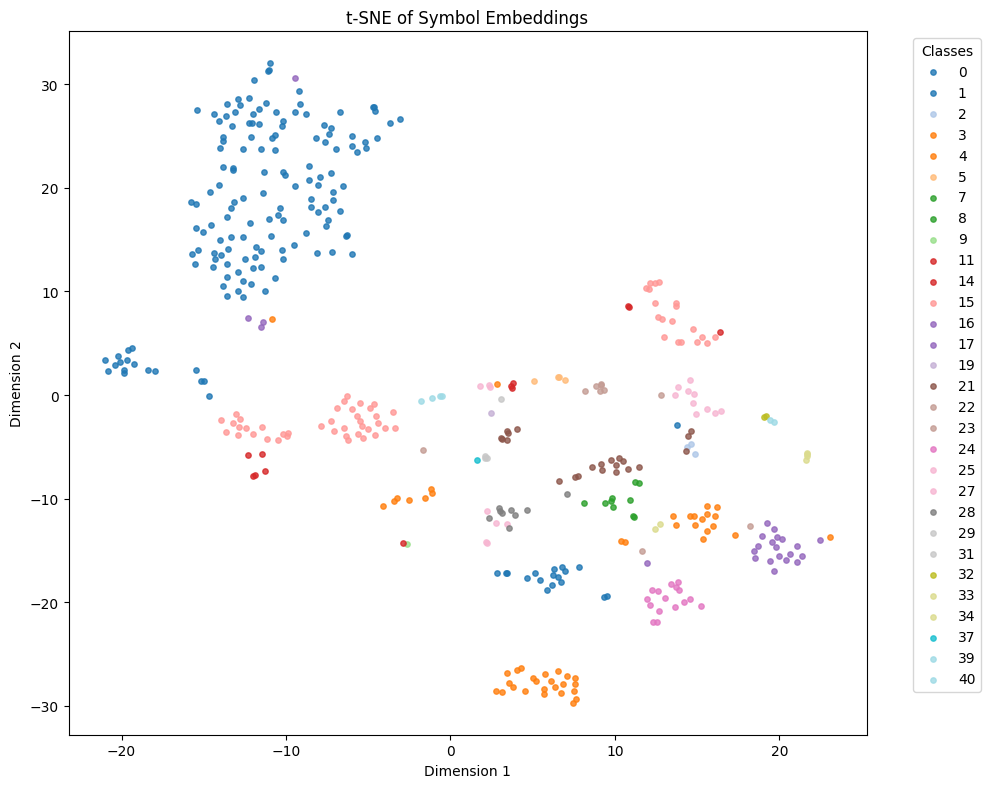

In [51]:
crops, class_ids = reference_evaluator.load_crops()
feats = evaluator.compute_embeddings(crops)
plot_tsne(feats, class_ids)

## Conclusion


The 1-NN accuracy obtained using the fine-tuned SimCLR embeddings is roughly the same as the one obtained with the plain ResNet backbone.  
Moreover, this accuracy is also comparable to the accuracy on a part of the final training set. This means that lowering the contrastive loss did not translate into more discriminative embeddings.

This suggests that, in our case, **the 2,000 training images had very limited influence compared to the initialized ImageNet weights**.  
The model mostly preserved the original ResNet representation, failing to reshape the embedding space in a way that better separates our specific symbols. In this setting, extra regularization may have been counter-productive because further damped the (already weak) signal from our small dataset. Anyway the limited number of epochs, constrained by computational resources, also likely prevented the model from escaping the strong ImageNet prior.  


